## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

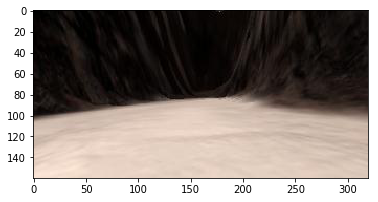

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

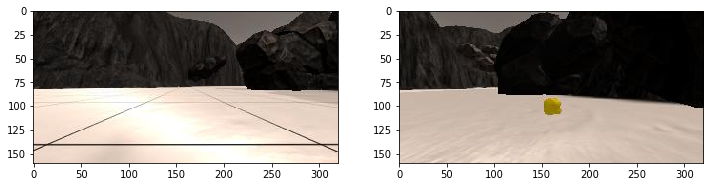

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

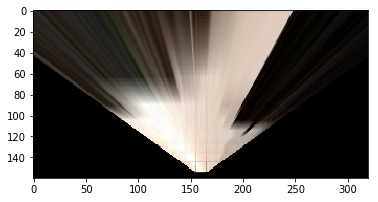

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

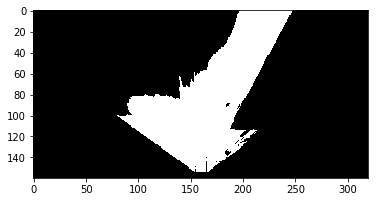

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

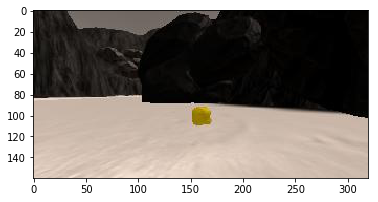

In [18]:
plt.imshow(rock_img)

In [24]:
print(rock_img[100,160])
print(rock_img.shape)

[148 115   8]
(160, 320, 3)


In [44]:
def obstacle_thrsh(img):
    return color_thresh(img)

def rock_thresh(img):
    lower_yellow = np.array([90,90,0])
    upper_yellow = np.array([255,255,50])
    mask = cv2.inRange(rock_img,lower_yellow,upper_yellow)
    return mask

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

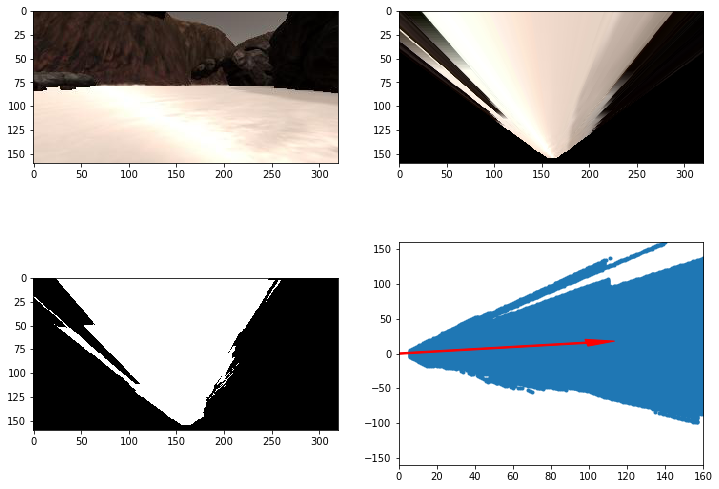

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [9]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    print('xpos,ypos,yaw')
    print(data.xpos[data.count],data.ypos[data.count],data.yaw[data.count])
    
    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                      [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                      [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                      ])
    print('destination')
    # 2) Apply perspective transform
    #warped = perspect_transform(grid_img, source, destination)
    warped = perspect_transform(img, source, destination)
    print('warped')
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    print('threshed')
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed)
    dist, angles = to_polar_coords(xpix, ypix)
    mean_dir = np.mean(angles)
    print('mean_dir is : ' +str(mean_dir))
    # 5) Convert rover-centric pixel values to world coords
    scale= 10
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    worldmap = data.worldmap
    print(xpos,'  ',ypos,'  ',yaw,'  ')
    x_pix_world, y_pix_world = pix_to_world(xpix,ypix, xpos, ypos, yaw, worldmap.shape[0],scale)
    print('conver to world coordinate')
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    #data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    #data.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[y_pix_world, x_pix_world, 2] += 1
    #print('update worldmap')

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [10]:
print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

121.7033 51.82202 197.8148


## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = '../output/test_mapping_linming.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25

In [12]:
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

xpos,ypos,yaw
121.7033 51.82202 197.8148
destination
warped
threshed
mean_dir is : 0.062068681705498494
121.7033    51.82202    197.8148   
conver to world coordinate
[MoviePy] >>>> Building video ../output/test_mapping_linming.mp4
[MoviePy] Writing video ../output/test_mapping_linming.mp4


  0%|                                                 | 0/1347 [00:00<?, ?it/s]

xpos,ypos,yaw
121.7033 51.82202 197.8148
destination
warped
threshed
mean_dir is : 0.062068681705498494
121.7033    51.82202    197.8148   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 195.1149
destination
warped
threshed
mean_dir is : 0.06286394359370479
121.7033    51.82202    195.1149   
conver to world coordinate


  0%|                                         | 2/1347 [00:00<01:33, 14.44it/s]

xpos,ypos,yaw
121.7033 51.82202 192.2617
destination
warped
threshed
mean_dir is : 0.10658487046520175
121.7033    51.82202    192.2617   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 189.7032
destination
warped
threshed
mean_dir is : 0.1795034970978963
121.7033    51.82202    189.7032   
conver to world coordinate


  0%|                                         | 4/1347 [00:00<01:37, 13.72it/s]

xpos,ypos,yaw
121.7033 51.82202 187.0031
destination
warped
threshed
mean_dir is : 0.2320887663962973
121.7033    51.82202    187.0031   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 183.4031
destination
warped
threshed
mean_dir is : 0.29794558077227207
121.7033    51.82202    183.4031   
conver to world coordinate


  0%|▏                                        | 6/1347 [00:00<01:38, 13.65it/s]

xpos,ypos,yaw
121.7033 51.82202 180.7032
destination
warped
threshed
mean_dir is : 0.3828664169334398
121.7033    51.82202    180.7032   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 178.1197
destination
warped
threshed
mean_dir is : 0.4343793740587014
121.7033    51.82202    178.1197   
conver to world coordinate


  1%|▏                                        | 8/1347 [00:00<01:41, 13.20it/s]

xpos,ypos,yaw
121.7033 51.82202 176.2529
destination
warped
threshed
mean_dir is : 0.4735881645749687
121.7033    51.82202    176.2529   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 174.7775
destination
warped
threshed
mean_dir is : 0.4751671607624406
121.7033    51.82202    174.7775   
conver to world coordinate


  1%|▎                                       | 10/1347 [00:00<01:39, 13.38it/s]

xpos,ypos,yaw
121.7033 51.82202 174.3542
destination
warped
threshed
mean_dir is : 0.4772923700544185
121.7033    51.82202    174.3542   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 174.8327
destination
warped
threshed
mean_dir is : 0.4720147022695242
121.7033    51.82202    174.8327   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 175.4839
destination
warped
threshed
mean_dir is : 0.4724498418370147
121.7033    51.82202    175.4839   
conver to world coordinate


  1%|▍                                       | 13/1347 [00:00<01:29, 14.84it/s]

xpos,ypos,yaw
121.7033 51.82202 175.7748
destination
warped
threshed
mean_dir is : 0.4787462096940773
121.7033    51.82202    175.7748   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 177.2035
destination
warped
threshed
mean_dir is : 0.4765320316402792
121.7033    51.82202    177.2035   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 179.0571
destination
warped
threshed
mean_dir is : 0.4732279912781496
121.7033    51.82202    179.0571   
conver to world coordinate
xpos,ypos,yaw
121.7033 51.82202 181.5109
destination
warped
threshed
mean_dir is : 0.4656702716791056
121.7033    51.82202    181.5109   
conver to world coordinate


  1%|▌                                       | 17/1347 [00:01<01:18, 16.84it/s]

xpos,ypos,yaw
121.7033 51.82202 185.111
destination
warped
threshed
mean_dir is : 0.41622734723955557
121.7033    51.82202    185.111   
conver to world coordinate
xpos,ypos,yaw
121.7031 51.82184 185.1243
destination
warped
threshed
mean_dir is : 0.344383593145547
121.7031    51.82184    185.1243   
conver to world coordinate


  1%|▌                                       | 19/1347 [00:01<01:18, 17.02it/s]

xpos,ypos,yaw
121.7011 51.821509999999996 185.2863
destination
warped
threshed
mean_dir is : 0.3420165100187237
121.7011    51.821509999999996    185.2863   
conver to world coordinate
xpos,ypos,yaw
121.6976 51.82092 185.3452
destination
warped
threshed
mean_dir is : 0.3283617097536254
121.6976    51.82092    185.3452   
conver to world coordinate


  2%|▌                                       | 21/1347 [00:01<01:19, 16.75it/s]

xpos,ypos,yaw
121.6883 51.818909999999995 185.6892
destination
warped
threshed
mean_dir is : 0.3172117818287211
121.6883    51.818909999999995    185.6892   
conver to world coordinate
xpos,ypos,yaw
121.6772 51.8166 185.9457
destination
warped
threshed
mean_dir is : 0.250366353677599
121.6772    51.8166    185.9457   
conver to world coordinate
xpos,ypos,yaw
121.6633 51.81365 186.2549
destination
warped
threshed
mean_dir is : 0.27925309748332133
121.6633    51.81365    186.2549   
conver to world coordinate


  2%|▋                                       | 24/1347 [00:01<01:15, 17.52it/s]

xpos,ypos,yaw
121.6402 51.80885 186.7972
destination
warped
threshed
mean_dir is : 0.37354966850105537
121.6402    51.80885    186.7972   
conver to world coordinate
xpos,ypos,yaw
121.6187 51.80375 187.1516
destination
warped
threshed
mean_dir is : 0.2809106677576194
121.6187    51.80375    187.1516   
conver to world coordinate
xpos,ypos,yaw
121.5923 51.79654 187.74200000000002
destination
warped
threshed
mean_dir is : 0.19070596023653505
121.5923    51.79654    187.74200000000002   
conver to world coordinate
xpos,ypos,yaw
121.5698 51.79072 188.2158
destination
warped
threshed
mean_dir is : 0.22626513854645341
121.5698    51.79072    188.2158   
conver to world coordinate


  2%|▊                                       | 28/1347 [00:01<01:10, 18.75it/s]

xpos,ypos,yaw
121.5431 51.78363 188.5643
destination
warped
threshed
mean_dir is : 0.22464854614809177
121.5431    51.78363    188.5643   
conver to world coordinate
xpos,ypos,yaw
121.5015 51.77237 189.0742
destination
warped
threshed
mean_dir is : 0.2243499428726894
121.5015    51.77237    189.0742   
conver to world coordinate
xpos,ypos,yaw
121.4671 51.76294 189.6819
destination
warped
threshed
mean_dir is : 0.2080612683017468
121.4671    51.76294    189.6819   
conver to world coordinate


  2%|▉                                       | 31/1347 [00:01<01:07, 19.46it/s]

xpos,ypos,yaw
121.4307 51.75253 190.3396
destination
warped
threshed
mean_dir is : 0.19849114946483623
121.4307    51.75253    190.3396   
conver to world coordinate
xpos,ypos,yaw
121.3783 51.73679 191.2836
destination
warped
threshed
mean_dir is : 0.19001592990403096
121.3783    51.73679    191.2836   
conver to world coordinate
xpos,ypos,yaw
121.3355 51.724740000000004 191.9038
destination
warped
threshed
mean_dir is : 0.17600871402222534
121.3355    51.724740000000004    191.9038   
conver to world coordinate
xpos,ypos,yaw
121.2903 51.71137 192.6253
destination
warped
threshed
mean_dir is : 0.1644534238893937
121.2903    51.71137    192.6253   
conver to world coordinate


  3%|█                                       | 35/1347 [00:01<01:04, 20.29it/s]

xpos,ypos,yaw
121.226 51.689640000000004 193.8162
destination
warped
threshed
mean_dir is : 0.13804610875787307
121.226    51.689640000000004    193.8162   
conver to world coordinate
xpos,ypos,yaw
121.1752 51.67136 194.8315
destination
warped
threshed
mean_dir is : 0.11246129426480446
121.1752    51.67136    194.8315   
conver to world coordinate
xpos,ypos,yaw
121.1218 51.65198 195.7623
destination
warped
threshed
mean_dir is : 0.09348792111273409
121.1218    51.65198    195.7623   
conver to world coordinate
xpos,ypos,yaw
121.0453 51.62487 196.5763
destination
warped
threshed
mean_dir is : 0.07344167319778924
121.0453    51.62487    196.5763   
conver to world coordinate


  3%|█▏                                      | 39/1347 [00:01<01:01, 21.16it/s]

xpos,ypos,yaw
120.9842 51.60452 196.8833
destination
warped
threshed
mean_dir is : 0.059243660608334164
120.9842    51.60452    196.8833   
conver to world coordinate
xpos,ypos,yaw
120.9207 51.58466 196.9178
destination
warped
threshed
mean_dir is : 0.05212215257174256
120.9207    51.58466    196.9178   
conver to world coordinate
xpos,ypos,yaw
120.8314 51.55767 196.8828
destination
warped
threshed
mean_dir is : 0.0510632540618591
120.8314    51.55767    196.8828   
conver to world coordinate
xpos,ypos,yaw
120.76100000000001 51.536609999999996 196.85
destination
warped
threshed
mean_dir is : 0.04954131135416449
120.76100000000001    51.536609999999996    196.85   
conver to world coordinate


  3%|█▎                                      | 43/1347 [00:01<01:00, 21.55it/s]

xpos,ypos,yaw
120.68799999999999 51.51477 196.8277
destination
warped
threshed
mean_dir is : 0.0438718123304543
120.68799999999999    51.51477    196.8277   
conver to world coordinate
xpos,ypos,yaw
120.5863 51.48442 196.7887
destination
warped
threshed
mean_dir is : 0.041801614505571134
120.5863    51.48442    196.7887   
conver to world coordinate
xpos,ypos,yaw
120.5068 51.460770000000004 196.7689
destination
warped
threshed
mean_dir is : 0.04011056624694783
120.5068    51.460770000000004    196.7689   
conver to world coordinate


  3%|█▎                                      | 46/1347 [00:02<00:59, 21.81it/s]

xpos,ypos,yaw
120.4246 51.43636 196.7526
destination
warped
threshed
mean_dir is : 0.03994330049128174
120.4246    51.43636    196.7526   
conver to world coordinate
xpos,ypos,yaw
120.3109 51.402590000000004 196.7368
destination
warped
threshed
mean_dir is : 0.04235223043144422
120.3109    51.402590000000004    196.7368   
conver to world coordinate
xpos,ypos,yaw
120.2223 51.37634 196.7225
destination
warped
threshed
mean_dir is : 0.038364864596771624
120.2223    51.37634    196.7225   
conver to world coordinate


  4%|█▍                                      | 49/1347 [00:02<00:59, 21.94it/s]

xpos,ypos,yaw
120.1311 51.34933 196.7124
destination
warped
threshed
mean_dir is : 0.029798706104238303
120.1311    51.34933    196.7124   
conver to world coordinate
xpos,ypos,yaw
120.0054 51.31212 196.6977
destination
warped
threshed
mean_dir is : 0.020745113879232207
120.0054    51.31212    196.6977   
conver to world coordinate
xpos,ypos,yaw
119.90799999999999 51.28331 196.6857
destination
warped
threshed
mean_dir is : 0.018302461875739705
119.90799999999999    51.28331    196.6857   
conver to world coordinate


  4%|█▌                                      | 52/1347 [00:02<00:59, 21.60it/s]

xpos,ypos,yaw
119.8079 51.25377 196.676
destination
warped
threshed
mean_dir is : 0.01965258428805347
119.8079    51.25377    196.676   
conver to world coordinate
xpos,ypos,yaw
119.6703 51.21317 196.6603
destination
warped
threshed
mean_dir is : 0.015091679573445196
119.6703    51.21317    196.6603   
conver to world coordinate
xpos,ypos,yaw
119.5641 51.18184 196.6489
destination
warped
threshed
mean_dir is : 0.025309656903171406
119.5641    51.18184    196.6489   
conver to world coordinate


  4%|█▋                                      | 55/1347 [00:02<00:59, 21.68it/s]

xpos,ypos,yaw
119.4553 51.14978 196.6379
destination
warped
threshed
mean_dir is : 0.03224868195371194
119.4553    51.14978    196.6379   
conver to world coordinate
xpos,ypos,yaw
119.3061 51.10587 196.6245
destination
warped
threshed
mean_dir is : 0.048971462947675515
119.3061    51.10587    196.6245   
conver to world coordinate
xpos,ypos,yaw
119.1912 51.072070000000004 196.6134
destination
warped
threshed
mean_dir is : 0.051552639972597375
119.1912    51.072070000000004    196.6134   
conver to world coordinate


  4%|█▋                                      | 58/1347 [00:02<00:59, 21.70it/s]

xpos,ypos,yaw
119.0736 51.03752 196.6007
destination
warped
threshed
mean_dir is : 0.052611851848149205
119.0736    51.03752    196.6007   
conver to world coordinate
xpos,ypos,yaw
118.913 50.99033 196.58599999999998
destination
warped
threshed
mean_dir is : 0.0521570976779531
118.913    50.99033    196.58599999999998   
conver to world coordinate
xpos,ypos,yaw
118.7895 50.9541 196.575
destination
warped
threshed
mean_dir is : 0.05201142842844405
118.7895    50.9541    196.575   
conver to world coordinate


  5%|█▊                                      | 61/1347 [00:02<00:59, 21.43it/s]

xpos,ypos,yaw
118.6634 50.91735 196.5244
destination
warped
threshed
mean_dir is : 0.06332338771949496
118.6634    50.91735    196.5244   
conver to world coordinate
xpos,ypos,yaw
118.4907 50.870470000000005 195.8719
destination
warped
threshed
mean_dir is : 0.04710437272381285
118.4907    50.870470000000005    195.8719   
conver to world coordinate
xpos,ypos,yaw
118.3574 50.83878 194.8428
destination
warped
threshed
mean_dir is : 0.07623780299378283
118.3574    50.83878    194.8428   
conver to world coordinate


  5%|█▉                                      | 64/1347 [00:02<00:59, 21.61it/s]

xpos,ypos,yaw
118.2213 50.81149 193.3475
destination
warped
threshed
mean_dir is : 0.10837629746841783
118.2213    50.81149    193.3475   
conver to world coordinate
xpos,ypos,yaw
118.0366 50.77916 191.2854
destination
warped
threshed
mean_dir is : 0.1687906456951436
118.0366    50.77916    191.2854   
conver to world coordinate
xpos,ypos,yaw
117.8945 50.7561 190.1824
destination
warped
threshed
mean_dir is : 0.12062842591648938
117.8945    50.7561    190.1824   
conver to world coordinate


  5%|█▉                                      | 67/1347 [00:03<00:58, 21.78it/s]

xpos,ypos,yaw
117.7491 50.73274 189.5321
destination
warped
threshed
mean_dir is : 0.18217466278605413
117.7491    50.73274    189.5321   
conver to world coordinate
xpos,ypos,yaw
117.5504 50.699009999999994 189.3502
destination
warped
threshed
mean_dir is : 0.20558837408968603
117.5504    50.699009999999994    189.3502   
conver to world coordinate
xpos,ypos,yaw
117.3986 50.67318 189.34799999999998
destination
warped
threshed
mean_dir is : 0.2168801403582503
117.3986    50.67318    189.34799999999998   
conver to world coordinate


  5%|██                                      | 70/1347 [00:03<00:59, 21.47it/s]

xpos,ypos,yaw
117.2452 50.64714 189.3632
destination
warped
threshed
mean_dir is : 0.22964336870386884
117.2452    50.64714    189.3632   
conver to world coordinate
xpos,ypos,yaw
117.0404 50.60955 189.7608
destination
warped
threshed
mean_dir is : 0.20273977788339506
117.0404    50.60955    189.7608   
conver to world coordinate
xpos,ypos,yaw
116.8864 50.5811 190.013
destination
warped
threshed
mean_dir is : 0.2160033812400631
116.8864    50.5811    190.013   
conver to world coordinate


  5%|██▏                                     | 73/1347 [00:03<00:59, 21.35it/s]

xpos,ypos,yaw
116.7311 50.55343 190.0648
destination
warped
threshed
mean_dir is : 0.22329078003289962
116.7311    50.55343    190.0648   
conver to world coordinate
xpos,ypos,yaw
116.5736 50.526 190.0629
destination
warped
threshed
mean_dir is : 0.22556005416307662
116.5736    50.526    190.0629   
conver to world coordinate
xpos,ypos,yaw
116.4134 50.50014 189.6776
destination
warped
threshed
mean_dir is : 0.20674869677060412
116.4134    50.50014    189.6776   
conver to world coordinate


  6%|██▎                                     | 76/1347 [00:03<00:59, 21.49it/s]

xpos,ypos,yaw
116.25 50.477579999999996 188.8109
destination
warped
threshed
mean_dir is : 0.18732625368176048
116.25    50.477579999999996    188.8109   
conver to world coordinate
xpos,ypos,yaw
116.0287 50.455490000000005 186.8086
destination
warped
threshed
mean_dir is : 0.14930942736250635
116.0287    50.455490000000005    186.8086   
conver to world coordinate
xpos,ypos,yaw
115.8627 50.44342 185.0104
destination
warped
threshed
mean_dir is : -0.017832511675827986
115.8627    50.44342    185.0104   
conver to world coordinate


  6%|██▎                                     | 79/1347 [00:03<00:58, 21.62it/s]

xpos,ypos,yaw
115.6943 50.43963 182.9391
destination
warped
threshed
mean_dir is : 0.017881902188977783
115.6943    50.43963    182.9391   
conver to world coordinate
xpos,ypos,yaw
115.4669 50.44126 180.4272
destination
warped
threshed
mean_dir is : -0.07887331164623577
115.4669    50.44126    180.4272   
conver to world coordinate
xpos,ypos,yaw
115.2937 50.44567 179.046
destination
warped
threshed
mean_dir is : -0.16024330958612482
115.2937    50.44567    179.046   
conver to world coordinate
xpos,ypos,yaw
115.1176 50.451859999999996 178.1538
destination
warped
threshed
mean_dir is : -0.19917568729531362
115.1176    50.451859999999996    178.1538   
conver to world coordinate


  6%|██▍                                     | 83/1347 [00:03<00:57, 21.90it/s]

xpos,ypos,yaw
114.8773 50.461090000000006 177.6075
destination
warped
threshed
mean_dir is : -0.22994522412359658
114.8773    50.461090000000006    177.6075   
conver to world coordinate
xpos,ypos,yaw
114.6936 50.470859999999995 177.109
destination
warped
threshed
mean_dir is : -0.30798669370491505
114.6936    50.470859999999995    177.109   
conver to world coordinate
xpos,ypos,yaw
114.5069 50.48048 176.8516
destination
warped
threshed
mean_dir is : -0.3743056106938065
114.5069    50.48048    176.8516   
conver to world coordinate
xpos,ypos,yaw
114.2527 50.49368 176.7783
destination
warped
threshed
mean_dir is : -0.44561541894577733
114.2527    50.49368    176.7783   
conver to world coordinate


  6%|██▌                                     | 87/1347 [00:03<00:56, 22.16it/s]

xpos,ypos,yaw
114.0582 50.50407 176.7773
destination
warped
threshed
mean_dir is : -0.5234034739929992
114.0582    50.50407    176.7773   
conver to world coordinate
xpos,ypos,yaw
113.8608 50.514509999999994 176.7891
destination
warped
threshed
mean_dir is : -0.5665050241073994
113.8608    50.514509999999994    176.7891   
conver to world coordinate
xpos,ypos,yaw
113.5932 50.52957 176.702
destination
warped
threshed
mean_dir is : -0.565425041893028
113.5932    50.52957    176.702   
conver to world coordinate
xpos,ypos,yaw
113.3901 50.54441 176.1716
destination
warped
threshed
mean_dir is : -0.5531841700592259
113.3901    50.54441    176.1716   
conver to world coordinate


  7%|██▋                                     | 91/1347 [00:04<00:55, 22.51it/s]

xpos,ypos,yaw
113.186 50.5638 175.1141
destination
warped
threshed
mean_dir is : -0.5489230639272401
113.186    50.5638    175.1141   
conver to world coordinate
xpos,ypos,yaw
112.9144 50.60021 172.7622
destination
warped
threshed
mean_dir is : -0.5510607017669996
112.9144    50.60021    172.7622   
conver to world coordinate
xpos,ypos,yaw
112.7115 50.63695 170.5371
destination
warped
threshed
mean_dir is : -0.5720178131381154
112.7115    50.63695    170.5371   
conver to world coordinate


  7%|██▊                                     | 94/1347 [00:04<00:55, 22.61it/s]

xpos,ypos,yaw
112.5095 50.68144 168.2049
destination
warped
threshed
mean_dir is : -0.5920491447743391
112.5095    50.68144    168.2049   
conver to world coordinate
xpos,ypos,yaw
112.2421 50.75308 165.0756
destination
warped
threshed
mean_dir is : -0.6148503019481022
112.2421    50.75308    165.0756   
conver to world coordinate
xpos,ypos,yaw
112.0433 50.81604 162.76
destination
warped
threshed
mean_dir is : -0.623068353066571
112.0433    50.81604    162.76   
conver to world coordinate


  7%|██▉                                     | 97/1347 [00:04<00:55, 22.52it/s]

xpos,ypos,yaw
111.8413 50.885220000000004 160.6885
destination
warped
threshed
mean_dir is : -0.6257318795490597
111.8413    50.885220000000004    160.6885   
conver to world coordinate
xpos,ypos,yaw
111.569 50.98877 157.9754
destination
warped
threshed
mean_dir is : -0.6182059002287057
111.569    50.98877    157.9754   
conver to world coordinate
xpos,ypos,yaw
111.3686 51.07454 155.7855
destination
warped
threshed
mean_dir is : -0.5966491460224881
111.3686    51.07454    155.7855   
conver to world coordinate


  7%|██▉                                    | 100/1347 [00:04<00:55, 22.44it/s]

xpos,ypos,yaw
111.1702 51.1741 153.4953
destination
warped
threshed
mean_dir is : -0.5451994019405378
111.1702    51.1741    153.4953   
conver to world coordinate
xpos,ypos,yaw
110.9099 51.31904 150.5045
destination
warped
threshed
mean_dir is : -0.5223443297930827
110.9099    51.31904    150.5045   
conver to world coordinate
xpos,ypos,yaw
110.7174 51.436609999999995 148.2601
destination
warped
threshed
mean_dir is : -0.5130161572036467
110.7174    51.436609999999995    148.2601   
conver to world coordinate


  8%|██▉                                    | 103/1347 [00:04<00:55, 22.59it/s]

xpos,ypos,yaw
110.5282 51.563179999999996 146.0182
destination
warped
threshed
mean_dir is : -0.48759269111684694
110.5282    51.563179999999996    146.0182   
conver to world coordinate
xpos,ypos,yaw
110.2822 51.74334 143.0358
destination
warped
threshed
mean_dir is : -0.470511127187772
110.2822    51.74334    143.0358   
conver to world coordinate
xpos,ypos,yaw
110.1037 51.887029999999996 140.7879
destination
warped
threshed
mean_dir is : -0.4373885175662771
110.1037    51.887029999999996    140.7879   
conver to world coordinate
xpos,ypos,yaw
109.93 52.03683 138.7358
destination
warped
threshed
mean_dir is : -0.4147939060937629
109.93    52.03683    138.7358   
conver to world coordinate


  8%|███                                    | 107/1347 [00:04<00:54, 22.82it/s]

xpos,ypos,yaw
109.7053 52.2433 136.702
destination
warped
threshed
mean_dir is : -0.41247473492315706
109.7053    52.2433    136.702   
conver to world coordinate
xpos,ypos,yaw
109.5434 52.40397 135.2747
destination
warped
threshed
mean_dir is : -0.3942421478283249
109.5434    52.40397    135.2747   
conver to world coordinate
xpos,ypos,yaw
109.3866 52.567859999999996 133.5229
destination
warped
threshed
mean_dir is : -0.3845745418954075
109.3866    52.567859999999996    133.5229   
conver to world coordinate


  8%|███▏                                   | 110/1347 [00:04<00:53, 22.94it/s]

xpos,ypos,yaw
109.1875 52.792790000000004 130.8742
destination
warped
threshed
mean_dir is : -0.3764252140358225
109.1875    52.792790000000004    130.8742   
conver to world coordinate
xpos,ypos,yaw
109.0464 52.96685 128.9887
destination
warped
threshed
mean_dir is : -0.35411941517277223
109.0464    52.96685    128.9887   
conver to world coordinate
xpos,ypos,yaw
108.9119 53.144740000000006 126.9272
destination
warped
threshed
mean_dir is : -0.342545098030689
108.9119    53.144740000000006    126.9272   
conver to world coordinate


  8%|███▎                                   | 113/1347 [00:04<00:53, 23.05it/s]

xpos,ypos,yaw
108.7441 53.38757 124.0852
destination
warped
threshed
mean_dir is : -0.32499762957154193
108.7441    53.38757    124.0852   
conver to world coordinate
xpos,ypos,yaw
108.6279 53.574630000000006 121.9125
destination
warped
threshed
mean_dir is : -0.30201197996599466
108.6279    53.574630000000006    121.9125   
conver to world coordinate
xpos,ypos,yaw
108.5181 53.764030000000005 119.745
destination
warped
threshed
mean_dir is : -0.281401268368871
108.5181    53.764030000000005    119.745   
conver to world coordinate


  9%|███▎                                   | 116/1347 [00:05<00:53, 23.15it/s]

xpos,ypos,yaw
108.3841 54.0214 116.9461
destination
warped
threshed
mean_dir is : -0.2531988301774408
108.3841    54.0214    116.9461   
conver to world coordinate
xpos,ypos,yaw
108.2918 54.21742 115.2437
destination
warped
threshed
mean_dir is : -0.21675679890774938
108.2918    54.21742    115.2437   
conver to world coordinate
xpos,ypos,yaw
108.2027 54.41418 114.0142
destination
warped
threshed
mean_dir is : -0.19879421576623235
108.2027    54.41418    114.0142   
conver to world coordinate
xpos,ypos,yaw
108.0921 54.67876 112.509
destination
warped
threshed
mean_dir is : -0.17901853809386595
108.0921    54.67876    112.509   
conver to world coordinate


  9%|███▍                                   | 120/1347 [00:05<00:52, 23.32it/s]

xpos,ypos,yaw
108.0161 54.87919 111.1497
destination
warped
threshed
mean_dir is : -0.15783808456902618
108.0161    54.87919    111.1497   
conver to world coordinate
xpos,ypos,yaw
107.9425 55.07909 110.0105
destination
warped
threshed
mean_dir is : -0.1457440901069386
107.9425    55.07909    110.0105   
conver to world coordinate
xpos,ypos,yaw
107.8471 55.34681 109.1937
destination
warped
threshed
mean_dir is : -0.13274739167438618
107.8471    55.34681    109.1937   
conver to world coordinate


  9%|███▌                                   | 123/1347 [00:05<00:52, 23.42it/s]

xpos,ypos,yaw
107.7765 55.5489 109.0184
destination
warped
threshed
mean_dir is : -0.11273427704771788
107.7765    55.5489    109.0184   
conver to world coordinate
xpos,ypos,yaw
107.706 55.75236999999999 108.9725
destination
warped
threshed
mean_dir is : -0.10910182157520533
107.706    55.75236999999999    108.9725   
conver to world coordinate
xpos,ypos,yaw
107.6111 56.02705 108.9626
destination
warped
threshed
mean_dir is : -0.1029379536287904
107.6111    56.02705    108.9626   
conver to world coordinate


  9%|███▋                                   | 126/1347 [00:05<00:52, 23.48it/s]

xpos,ypos,yaw
107.539 56.236259999999994 108.9668
destination
warped
threshed
mean_dir is : -0.10542212586688719
107.539    56.236259999999994    108.9668   
conver to world coordinate
xpos,ypos,yaw
107.4661 56.44836 108.9372
destination
warped
threshed
mean_dir is : -0.10851039815956375
107.4661    56.44836    108.9372   
conver to world coordinate
xpos,ypos,yaw
107.3723 56.736419999999995 108.2591
destination
warped
threshed
mean_dir is : -0.08950540353266638
107.3723    56.736419999999995    108.2591   
conver to world coordinate


 10%|███▋                                   | 129/1347 [00:05<00:51, 23.54it/s]

xpos,ypos,yaw
107.3027 56.95568000000001 107.6881
destination
warped
threshed
mean_dir is : -0.08838649218948116
107.3027    56.95568000000001    107.6881   
conver to world coordinate
xpos,ypos,yaw
107.2315 57.17635 107.4813
destination
warped
threshed
mean_dir is : -0.07023486346847486
107.2315    57.17635    107.4813   
conver to world coordinate
xpos,ypos,yaw
107.1357 57.47334 107.4262
destination
warped
threshed
mean_dir is : -0.031885897733370534
107.1357    57.47334    107.4262   
conver to world coordinate


 10%|███▊                                   | 132/1347 [00:05<00:51, 23.61it/s]

xpos,ypos,yaw
107.0654 57.698919999999994 107.3908
destination
warped
threshed
mean_dir is : -0.040633018505346216
107.0654    57.698919999999994    107.3908   
conver to world coordinate
xpos,ypos,yaw
106.9956 57.925059999999995 107.3599
destination
warped
threshed
mean_dir is : -0.040192861101115016
106.9956    57.925059999999995    107.3599   
conver to world coordinate
xpos,ypos,yaw
106.9038 58.229780000000005 107.0005
destination
warped
threshed
mean_dir is : -0.036076693370559416
106.9038    58.229780000000005    107.0005   
conver to world coordinate
xpos,ypos,yaw
106.8377 58.46205 106.2238
destination
warped
threshed
mean_dir is : -0.023928826836183893
106.8377    58.46205    106.2238   
conver to world coordinate


 10%|███▉                                   | 136/1347 [00:05<00:50, 23.76it/s]

xpos,ypos,yaw
106.7765 58.697630000000004 104.9254
destination
warped
threshed
mean_dir is : -0.009343897376548222
106.7765    58.697630000000004    104.9254   
conver to world coordinate
xpos,ypos,yaw
106.705 59.014340000000004 102.4272
destination
warped
threshed
mean_dir is : 0.012843635878856865
106.705    59.014340000000004    102.4272   
conver to world coordinate
xpos,ypos,yaw
106.6573 59.25455 100.7838
destination
warped
threshed
mean_dir is : 0.02807120757523004
106.6573    59.25455    100.7838   
conver to world coordinate
xpos,ypos,yaw
106.6134 59.49734 99.61606
destination
warped
threshed
mean_dir is : 0.042947594179185
106.6134    59.49734    99.61606   
conver to world coordinate


 10%|████                                   | 140/1347 [00:05<00:50, 23.89it/s]

xpos,ypos,yaw
106.5572 59.82533000000001 98.90997
destination
warped
threshed
mean_dir is : 0.06632473563937102
106.5572    59.82533000000001    98.90997   
conver to world coordinate
xpos,ypos,yaw
106.5143 60.0746 99.00894
destination
warped
threshed
mean_dir is : 0.0616654591395622
106.5143    60.0746    99.00894   
conver to world coordinate
xpos,ypos,yaw
106.4681 60.326730000000005 99.64206
destination
warped
threshed
mean_dir is : 0.061460707401358165
106.4681    60.326730000000005    99.64206   
conver to world coordinate
xpos,ypos,yaw
106.3968 60.66619 101.3771
destination
warped
threshed
mean_dir is : 0.055686192948551656
106.3968    60.66619    101.3771   
conver to world coordinate


 11%|████▏                                  | 144/1347 [00:05<00:50, 24.02it/s]

xpos,ypos,yaw
106.3329 60.92183000000001 103.2948
destination
warped
threshed
mean_dir is : 0.040038827353632345
106.3329    60.92183000000001    103.2948   
conver to world coordinate
xpos,ypos,yaw
106.2598 61.177569999999996 105.444
destination
warped
threshed
mean_dir is : 0.043469059409618475
106.2598    61.177569999999996    105.444   
conver to world coordinate
xpos,ypos,yaw
106.1553 61.51753000000001 107.8098
destination
warped
threshed
mean_dir is : 0.037630201387970234
106.1553    61.51753000000001    107.8098   
conver to world coordinate
xpos,ypos,yaw
106.075 61.77106 109.0881
destination
warped
threshed
mean_dir is : 0.03795028890570953
106.075    61.77106    109.0881   
conver to world coordinate


 11%|████▎                                  | 148/1347 [00:06<00:49, 24.11it/s]

xpos,ypos,yaw
105.9955 62.023109999999996 109.7181
destination
warped
threshed
mean_dir is : 0.03198653172121073
105.9955    62.023109999999996    109.7181   
conver to world coordinate
xpos,ypos,yaw
105.8856 62.364940000000004 109.8354
destination
warped
threshed
mean_dir is : -0.009874474916469344
105.8856    62.364940000000004    109.8354   
conver to world coordinate
xpos,ypos,yaw
105.7967 62.626580000000004 109.5819
destination
warped
threshed
mean_dir is : -0.03187511662159178
105.7967    62.626580000000004    109.5819   
conver to world coordinate


 11%|████▎                                  | 151/1347 [00:06<00:49, 24.08it/s]

xpos,ypos,yaw
105.7048 62.890519999999995 109.3644
destination
warped
threshed
mean_dir is : -0.037125066342907506
105.7048    62.890519999999995    109.3644   
conver to world coordinate
xpos,ypos,yaw
105.58 63.246390000000005 109.2643
destination
warped
threshed
mean_dir is : -0.050998812385984055
105.58    63.246390000000005    109.2643   
conver to world coordinate
xpos,ypos,yaw
105.4857 63.51619 109.2329
destination
warped
threshed
mean_dir is : -0.02725746719618448
105.4857    63.51619    109.2329   
conver to world coordinate


 11%|████▍                                  | 154/1347 [00:06<00:49, 24.10it/s]

xpos,ypos,yaw
105.3906 63.78824 109.2138
destination
warped
threshed
mean_dir is : -0.07056735142552334
105.3906    63.78824    109.2138   
conver to world coordinate
xpos,ypos,yaw
105.2614 64.15305 109.2447
destination
warped
threshed
mean_dir is : -0.04317827138609209
105.2614    64.15305    109.2447   
conver to world coordinate
xpos,ypos,yaw
105.1634 64.42855 109.2832
destination
warped
threshed
mean_dir is : -0.06125836399303496
105.1634    64.42855    109.2832   
conver to world coordinate


 12%|████▌                                  | 157/1347 [00:06<00:49, 24.15it/s]

xpos,ypos,yaw
105.0638 64.70421999999999 109.3386
destination
warped
threshed
mean_dir is : -0.08450576859939256
105.0638    64.70421999999999    109.3386   
conver to world coordinate
xpos,ypos,yaw
104.9322 65.07481999999999 109.3413
destination
warped
threshed
mean_dir is : -0.09606277194124466
104.9322    65.07481999999999    109.3413   
conver to world coordinate
xpos,ypos,yaw
104.8342 65.35421 109.3241
destination
warped
threshed
mean_dir is : -0.09816276375867249
104.8342    65.35421    109.3241   
conver to world coordinate


 12%|████▋                                  | 160/1347 [00:06<00:49, 24.18it/s]

xpos,ypos,yaw
104.7364 65.63497 109.2968
destination
warped
threshed
mean_dir is : -0.09749037661461146
104.7364    65.63497    109.2968   
conver to world coordinate
xpos,ypos,yaw
104.6057 66.01255 109.2554
destination
warped
threshed
mean_dir is : -0.0850927457615231
104.6057    66.01255    109.2554   mean_dir is : 0.00025352879954663207
103.5652    69.43656    105.6014   
conver to world coordinate
xpos,ypos,yaw
103.4566 69.82131 105.6206
destination
warped
threshed
mean_dir is : 0.03910422357412808
103.4566    69.82131    105.6206   
conver to world coordinate
xpos,ypos,yaw
103.3756 70.11153 105.5432
destination
warped
threshed
mean_dir is : 0.04094277718028491
103.3756    70.11153    105.5432   
conver to world coordinate


 13%|█████                                  | 175/1347 [00:07<00:47, 24.44it/s]

xpos,ypos,yaw
103.2971 70.40358 105.1402
destination
warped
threshed
mean_dir is : 0.03124011671885481
103.2971    70.40358    105.1402   
conver to world coordinate
xpos,ypos,yaw
103.1988 70.7934 103.9792
destination
warped
threshed
mean_dir is : 0.024180794535492885
103.1988    70.7934    103.9792   
conver to world coordinate
xpos,ypos,yaw
103.1331 71.08649 102.5445
destination
warped
threshed
mean_dir is : -0.018124165734816382
103.1331    71.08649    102.5445   
conver to world coordinate


 13%|█████▏                                 | 178/1347 [00:07<00:47, 24.47it/s]

xpos,ypos,yaw
103.0747 71.37779 100.6177
destination
warped
threshed
mean_dir is : -0.021521497681905487
103.0747    71.37779    100.6177   
conver to world coordinate
xpos,ypos,yaw
103.0077 71.76575 97.9408
destination
warped
threshed
mean_dir is : -0.006120400739764118
103.0077    71.76575    97.9408   
conver to world coordinate
xpos,ypos,yaw
102.965 72.06349 96.4389
destination
warped
threshed
mean_dir is : 0.05051885320833162
102.965    72.06349    96.4389   
conver to world coordinate


 13%|█████▏                                 | 181/1347 [00:07<00:48, 24.28it/s]

xpos,ypos,yaw
102.9298 72.36358 95.14078
destination
warped
threshed
mean_dir is : 0.060946717150570616
102.9298    72.36358    95.14078   
conver to world coordinate
xpos,ypos,yaw
102.8921 72.76189000000001 93.91561999999999
destination
warped
threshed
mean_dir is : 0.05902845473532363
102.8921    72.76189000000001    93.91561999999999   
conver to world coordinate
xpos,ypos,yaw
102.8695 73.06139 93.48461999999999
destination
warped
threshed
mean_dir is : 0.07286249953658216
102.8695    73.06139    93.48461999999999   
conver to world coordinate


 14%|█████▎                                 | 184/1347 [00:07<00:47, 24.26it/s]

xpos,ypos,yaw
102.8493 73.36189 93.35831
destination
warped
threshed
mean_dir is : 0.07469080402893365
102.8493    73.36189    93.35831   
conver to world coordinate
xpos,ypos,yaw
102.8202 73.76375999999999 93.81158
destination
warped
threshed
mean_dir is : 0.06096283261302987
102.8202    73.76375999999999    93.81158   
conver to world coordinate
xpos,ypos,yaw
102.7969 74.0663 94.27646
destination
warped
threshed
mean_dir is : 0.04483522156933002
102.7969    74.0663    94.27646   
conver to world coordinate


 14%|█████▍                                 | 187/1347 [00:07<00:47, 24.25it/s]

xpos,ypos,yaw
102.7736 74.36945 94.48148
destination
warped
threshed
mean_dir is : -0.009168234683942775
102.7736    74.36945    94.48148   
conver to world coordinate
xpos,ypos,yaw
102.7414 74.77394 94.60159
destination
warped
threshed
mean_dir is : 0.008587054248335054
102.7414    74.77394    94.60159   
conver to world coordinate 78.79314000000001 91.6582
destination
warped
threshed
mean_dir is : 0.1949957569467046
102.5657    78.79314000000001    91.6582   
conver to world coordinate
xpos,ypos,yaw
102.56 79.09385999999999 91.2066
destination
warped
threshed
mean_dir is : 0.18711097121978226
102.56    79.09385999999999    91.2066   
conver to world coordinate


 15%|█████▊                                 | 202/1347 [00:08<00:47, 24.29it/s]

xpos,ypos,yaw
102.5581 79.39513000000001 90.36725
destination
warped
threshed
mean_dir is : 0.19082733865767135
102.5581    79.39513000000001    90.36725   
conver to world coordinate
xpos,ypos,yaw
102.5642 79.79451 88.46959
destination
warped
threshed
mean_dir is : 0.21262728309125906
102.5642    79.79451    88.46959   
conver to world coordinate
xpos,ypos,yaw
102.5779 80.09234000000001 86.78851
destination
warped
threshed
mean_dir is : 0.2364568777574267
102.5779    80.09234000000001    86.78851   
conver to world coordinate


 15%|█████▉                                 | 205/1347 [00:08<00:47, 24.28it/s]

xpos,ypos,yaw
102.5995 80.38731 84.71749
destination
warped
threshed
mean_dir is : 0.20024310269733123
102.5995    80.38731    84.71749   
conver to world coordinate
xpos,ypos,yaw
102.6437 80.7757 81.82857
destination
warped
threshed
mean_dir is : 0.08762635055638289
102.6437    80.7757    81.82857   
conver to world coordinate
xpos,ypos,yaw
102.6884 81.06364 79.76777
destination
warped
threshed
mean_dir is : -0.01628921508738062
102.6884    81.06364    79.76777   
conver to world coordinate


 15%|██████                                 | 208/1347 [00:08<00:46, 24.29it/s]

xpos,ypos,yaw
102.7379 81.3548 78.18875
destination
warped
threshed
mean_dir is : -0.025377586086725377
102.7379    81.3548    78.18875   
conver to world coordinate
xpos,ypos,yaw
102.81 81.74829 76.87683
destination
warped
threshed
mean_dir is : -0.052353744706065686
102.81    81.74829    76.87683   
conver to world coordinate
xpos,ypos,yaw
102.8722 82.04773 76.17959
destination
warped
threshed
mean_dir is : -0.04597641765516959
102.8722    82.04773    76.17959   
conver to world coordinate


 16%|██████                                 | 211/1347 [00:08<00:46, 24.35it/s]

xpos,ypos,yaw
102.9404 82.34513000000001 75.92839000000001
destination
warped
threshed
mean_dir is : -0.0063003548542339425
102.9404    82.34513000000001    75.92839000000001   
conver to world coordinate
xpos,ypos,yaw
103.0351 82.7401 75.89639
destination
warped
threshed
mean_dir is : -0.06561044635859102
103.0351    82.7401    75.89639   
conver to world coordinate
xpos,ypos,yaw
103.1079 83.03584000000001 75.88416
destination
warped
threshed
mean_dir is : -0.051472874170151284
103.1079    83.03584000000001    75.88416   
conver to world coordinate


 16%|██████▏                                | 214/1347 [00:08<00:46, 24.40it/s]

xpos,ypos,yaw
103.1809 83.33099 75.90462
destination
warped
threshed
mean_dir is : -0.02985138595281663
103.1809    83.33099    75.90462   
conver to world coordinate
xpos,ypos,yaw
103.2784 83.72501 75.95759
destination
warped
threshed
mean_dir is : 0.023220918737934918
103.2784    83.72501    75.95759   
conver to world coordinate
xpos,ypos,yaw
103.352 84.02013000000001 75.98295999999999
destination
warped
threshed
mean_dir is : 0.038983256600747
103.352 xpos,ypos,yaw
104.3163 87.16239 67.39401
destination
warped
threshed
mean_dir is : -0.14241972337032116
104.3163    87.16239    67.39401   
conver to world coordinate
xpos,ypos,yaw
104.4749 87.51989 64.43259
destination
warped
threshed
mean_dir is : -0.19720202829467068
104.4749    87.51989    64.43259   
conver to world coordinate
xpos,ypos,yaw
104.6029 87.78494 62.51686
destination
warped
threshed
mean_dir is : -0.18876264017102456
104.6029    87.78494    62.51686   
conver to world coordinate


 17%|██████▋                                | 229/1347 [00:09<00:45, 24.36it/s]

xpos,ypos,yaw
104.7374 88.05228000000001 60.83858000000001
destination
warped
threshed
mean_dir is : -0.18103330321056463
104.7374    88.05228000000001    60.83858000000001   
conver to world coordinate
xpos,ypos,yaw
104.9287 88.40869 58.956309999999995
destination
warped
threshed
mean_dir is : -0.17065533672037406
104.9287    88.40869    58.956309999999995   
conver to world coordinate
xpos,ypos,yaw
105.0811 88.67188 57.6581
destination
warped
threshed
mean_dir is : -0.13421821697944622
105.0811    88.67188    57.6581   
conver to world coordinate


 17%|██████▋                                | 232/1347 [00:09<00:45, 24.42it/s]

xpos,ypos,yaw
105.24 88.92921 56.69555
destination
warped
threshed
mean_dir is : -0.10246864588197112
105.24    88.92921    56.69555   
conver to world coordinate
xpos,ypos,yaw
105.4586 89.26778 56.211980000000004
destination
warped
threshed
mean_dir is : -0.059033131052607754
105.4586    89.26778    56.211980000000004   
conver to world coordinate
xpos,ypos,yaw
105.6252 89.52044000000001 56.09451
destination
warped
threshed
mean_dir is : -0.027117636389753886
105.6252    89.52044000000001    56.09451   
conver to world coordinate


 17%|██████▊                                | 235/1347 [00:09<00:45, 24.46it/s]

xpos,ypos,yaw
105.7926 89.77245 56.063959999999994
destination
warped
threshed
mean_dir is : -0.02760755849596976
105.7926    89.77245    56.063959999999994   
conver to world coordinate
xpos,ypos,yaw
106.0187 90.1068 55.7914
destination
warped
threshed
mean_dir is : -0.06009094893717014
106.0187    90.1068    55.7914   
conver to world coordinate
xpos,ypos,yaw
106.1905 90.35540999999999 54.99896999999999
destination
warped
threshed
mean_dir is : -0.027006644344641846
106.1905    90.35540999999999    54.99896999999999   
conver to world coordinate


 18%|██████▉                                | 238/1347 [00:09<00:45, 24.49it/s]

xpos,ypos,yaw
106.3645 90.60011999999999 54.32108
destination
warped
threshed
mean_dir is : -0.009956380404603251
106.3645    90.60011999999999    54.32108   
conver to world coordinate
xpos,ypos,yaw
106.5988 90.92616 53.82281
destination
warped
threshed
mean_dir is : -0.0028321999527728364
106.5988    90.92616    53.82281   
conver to world coordinate
xpos,ypos,yaw
106.7755 91.17059 53.748290000000004
destination
warped
threshed
mean_dir is : 0.006716144602188072
106.7755    91.17059    53.748290000000004   
conver to world coordinate


 18%|██████▉                                | 241/1347 [00:09<00:45, 24.51it/s]

xpos,ypos,yaw
106.9529 91.41538 53.71634
destination
warped
threshed
mean_dir is : 0.026377177100826488
106.9529    91.41538    53.71634   
conver to world coordinate
xpos,ypos,yaw
107.1895 91.74068 53.72843
destination
warped
threshed
mean_dir is : 0.022015113595308108xpos,ypos,yaw
110.2496 94.72974 36.43665
destination
warped
threshed
mean_dir is : 0.05128871586107197
110.2496    94.72974    36.43665   
conver to world coordinate


 19%|███████▍                               | 256/1347 [00:10<00:44, 24.33it/s]

xpos,ypos,yaw
110.4938 94.91166 36.41069
destination
warped
threshed
mean_dir is : 0.07685825987667051
110.4938    94.91166    36.41069   
conver to world coordinate
xpos,ypos,yaw
110.8186 95.15302 36.41916
destination
warped
threshed
mean_dir is : 0.08448678257892607
110.8186    95.15302    36.41916   
conver to world coordinate
xpos,ypos,yaw
111.0639 95.33192 36.02937
destination
warped
threshed
mean_dir is : 0.09422827908678247
111.0639    95.33192    36.02937   
conver to world coordinate


 19%|███████▍                               | 259/1347 [00:10<00:44, 24.26it/s]

xpos,ypos,yaw
111.3095 95.50759000000001 35.45073
destination
warped
threshed
mean_dir is : 0.133416682876515
111.3095    95.50759000000001    35.45073   
conver to world coordinate
xpos,ypos,yaw
111.6361 95.73828 34.97607
destination
warped
threshed
mean_dir is : 0.15188111768365523
111.6361    95.73828    34.97607   
conver to world coordinate
xpos,ypos,yaw
111.8825 95.9108 34.90784
destination
warped
threshed
mean_dir is : 0.14150494689815987
111.8825    95.9108    34.90784   
conver to world coordinate


 19%|███████▌                               | 262/1347 [00:10<00:44, 24.23it/s]

xpos,ypos,yaw
112.1292 96.08263000000001 34.80314
destination
warped
threshed
mean_dir is : 0.14929491423156566
112.1292    96.08263000000001    34.80314   
conver to world coordinate
xpos,ypos,yaw
112.4599 96.30949 34.31477
destination
warped
threshed
mean_dir is : 0.13499924082687706
112.4599    96.30949    34.31477   
conver to world coordinate
xpos,ypos,yaw
112.7086 96.47946999999999 34.15166
destination
warped
threshed
mean_dir is : 0.14249788220542844
112.7086    96.47946999999999    34.15166   
conver to world coordinate


 20%|███████▋                               | 265/1347 [00:10<00:44, 24.26it/s]

xpos,ypos,yaw
112.9577 96.64924 34.08273
destination
warped
threshed
mean_dir is : 0.1486417903439783
112.9577    96.64924    34.08273   
conver to world coordinate
xpos,ypos,yaw
113.2882 96.87354 34.0608
destination
warped
threshed
mean_dir is : 0.1571920128970092
113.2882    96.87354    34.0608   
conver to world coordinate
xpos,ypos,yaw
113.5368 97.04124 34.04513
destination
warped
threshed
mean_dir is : 0.15009931565268464
113.5368    97.04124    34.04513   
conver to world coordinate


 20%|███████▊                               | 268/1347 [00:11<00:44, 24.31it/s]

xpos,ypos,yaw
113.7861 97.20897 34.02993
destination
warped
threshed
mean_dir is : 0.14408236292420956
113.7861    97.20897    34.02993   
conver to world coordinate
xpos,ypos,yaw
114.1187 97.43226999999999 33.994679999999995
destination
warped
threshed
mean_dir is : 0.13201071033724765
114.1187    97.43226999999999    33.994679999999995   
conver to world coordinate
xpos,ypos,yaw
114.369 97.59991 33.97099
destination
warped
threshed
mean_dir is : 0.13907036253995733
114.369    97.59991    33.97099   
conver to world coordinate


 20%|███████▊                               | 271/1347 [00:11<00:44, 24.25it/s]

xpos,ypos,yaw
114.6193 97.76723 33.93551
destination
warped
threshed


 21%|████████▏                              | 283/1347 [00:11<00:44, 24.13it/s]

xpos,ypos,yaw
117.9667 99.98127 33.41707
destination
warped
threshed
mean_dir is : 0.11048346759922748
117.9667    99.98127    33.41707   
conver to world coordinate
xpos,ypos,yaw
118.3006 100.1996 33.34515
destination
warped
threshed
mean_dir is : 0.09439092634744459
118.3006    100.1996    33.34515   
conver to world coordinate
xpos,ypos,yaw
118.5521 100.3637 33.30583
destination
warped
threshed
mean_dir is : 0.09079342468939719
118.5521    100.3637    33.30583   
conver to world coordinate


 21%|████████▎                              | 286/1347 [00:11<00:43, 24.17it/s]

xpos,ypos,yaw
118.8042 100.5279 33.3136
destination
warped
threshed
mean_dir is : 0.07882887818813786
118.8042    100.5279    33.3136   
conver to world coordinate
xpos,ypos,yaw
119.1401 100.7463 33.16705
destination
warped
threshed
mean_dir is : 0.08070124452498666
119.1401    100.7463    33.16705   
conver to world coordinate
xpos,ypos,yaw
119.3931 100.9104 33.15813
destination
warped
threshed
mean_dir is : 0.08047358650724387
119.3931    100.9104    33.15813   
conver to world coordinate


 21%|████████▎                              | 289/1347 [00:11<00:43, 24.20it/s]

xpos,ypos,yaw
119.646 101.074 33.080090000000006
destination
warped
threshed
mean_dir is : 0.09066365462816971
119.646    101.074    33.080090000000006   
conver to world coordinate
xpos,ypos,yaw
119.984 101.2923 33.044290000000004
destination
warped
threshed
mean_dir is : 0.0948867931852025
119.984    101.2923    33.044290000000004   
conver to world coordinate
xpos,ypos,yaw
120.2375 101.4557 32.988209999999995
destination
warped
threshed
mean_dir is : 0.11679005603685313
120.2375    101.4557    32.988209999999995   
conver to world coordinate


 22%|████████▍                              | 292/1347 [00:12<00:43, 24.21it/s]

xpos,ypos,yaw
120.4904 101.6183 32.94804
destination
warped
threshed
mean_dir is : 0.11188336571369265
120.4904    101.6183    32.94804   
conver to world coordinate
xpos,ypos,yaw
120.82600000000001 101.8338 32.89095
destination
warped
threshed
mean_dir is : 0.11657029164596247
120.82600000000001    101.8338    32.89095   
conver to world coordinate
xpos,ypos,yaw
121.0793 101.9956 32.78777
destination
warped
threshed
mean_dir is : 0.09304955463336216
121.0793    101.9956    32.78777   
conver to world coordinate


 22%|████████▌                              | 295/1347 [00:12<00:43, 24.25it/s]

xpos,ypos,yaw
121.3334 102.1556 32.335440000000006
destination
warped
threshed
mean_dir is : 0.09521559547688056
121.3334    102.1556    32.335440000000006   
conver to world coordinate
xpos,ypos,yaw
121.6763 102.3643 31.145870000000002
destination
warped
threshed
mean_dir is : 0.09968122550207281
121.6763    102.3643    31.145870000000002   
conver to world coordinate
xpos,ypos,yaw
121.9372 102.51299999999999 29.61855
destination
warped
threshed
mean_dir is : 0.12560338767107854
121.9372    102.51299999999999    29.61855   
conver to world coordinate


 22%|████████▋                              | 298/1347 [00:12<00:43, 24.16it/s]

xpos,ypos,yaw
122.1992 102.655 27.676059999999996
destination
warped
threshed
mean_dir is : 0.17360144024575358
122.1992    102.655    27.676059999999996   
conver to world coordinate
xpos,ypos,yaw
122.5506 102.8304 24.71945
destination
warped
threshed
   103.8696    16.77978   
conver to world coordinate
xpos,ypos,yaw
125.6662 103.9502 15.18011
destination
warped
threshed
mean_dir is : 0.260022996994567
125.6662    103.9502    15.18011   
conver to world coordinate
xpos,ypos,yaw
125.9549 104.0225 12.9901
destination
warped
threshed
mean_dir is : 0.2558080042764217
125.9549    104.0225    12.9901   
conver to world coordinate


 23%|█████████                              | 311/1347 [00:12<00:42, 24.15it/s]

xpos,ypos,yaw
126.3424 104.1018 10.337860000000001
destination
warped
threshed
mean_dir is : 0.2556272087405556
126.3424    104.1018    10.337860000000001   
conver to world coordinate
xpos,ypos,yaw
126.6324 104.1504 8.249664
destination
warped
threshed
mean_dir is : 0.13722974075281522
126.6324    104.1504    8.249664   
conver to world coordinate
xpos,ypos,yaw
126.9218 104.1901 6.465736
destination
warped
threshed
mean_dir is : 0.03618373823632971
126.9218    104.1901    6.465736   
conver to world coordinate


 23%|█████████                              | 314/1347 [00:12<00:42, 24.16it/s]

xpos,ypos,yaw
127.3113 104.2375 4.963997
destination
warped
threshed
mean_dir is : 0.10578525456234363
127.3113    104.2375    4.963997   
conver to world coordinate
xpos,ypos,yaw
127.60700000000001 104.2724 4.319817
destination
warped
threshed
mean_dir is : 0.08256374562746599
127.60700000000001    104.2724    4.319817   
conver to world coordinate
xpos,ypos,yaw
127.9058 104.3034 4.240921
destination
warped
threshed
mean_dir is : 0.09251564313179872
127.9058    104.3034    4.240921   
conver to world coordinate
xpos,ypos,yaw
128.3031 104.3365 4.302971
destination
warped
threshed
mean_dir is : 0.12332424225903352
128.3031    104.3365    4.302971   
conver to world coordinate


 24%|█████████▏                             | 318/1347 [00:13<00:42, 24.23it/s]

xpos,ypos,yaw
128.5995 104.3591 4.314445
destination
warped
threshed
mean_dir is : 0.1719571748455019
128.5995    104.3591    4.314445   
conver to world coordinate
xpos,ypos,yaw
128.8953 104.3814 4.318756
destination
warped
threshed
mean_dir is : 0.18236399400827935
128.8953    104.3814    4.318756   
conver to world coordinate
xpos,ypos,yaw
129.2903 104.4111 4.321121
destination
warped
threshed
mean_dir is : 0.20298582459041747
129.2903    104.4111    4.321121   
conver to world coordinate


 24%|█████████▎                             | 321/1347 [00:13<00:42, 24.23it/s]

xpos,ypos,yaw
129.5881 104.4333 4.322151
destination
warped
threshed
mean_dir is : 0.20100808763649916
129.5881    104.4333    4.322151   
conver to world coordinate
xpos,ypos,yaw
129.8877 104.4555 4.317337
destination
warped
threshed
mean_dir is : 0.23916584366931995
129.8877    104.4555    4.317337   
conver to world coordinate
xpos,ypos,yaw
130.2903 104.4846 4.293243
destination
warped
threshed
mean_dir is : 0.2515931019368722
130.2903    104.4846    4.293243   
conver to world coordinate


 24%|█████████▍                             | 324/1347 [00:13<00:42, 24.16it/s]

xpos,ypos,yaw
130.5929 104.5061 4.2672349999999994
destination
warped
threshed
mean_dir is : 0.21427340444628032
130.5929    104.5061    4.2672349999999994   
conver to world coordinate
xpos,ypos,yaw
130.89600000000002104.4594 349.9301
destination
warped
threshed
mean_dir is : -0.07761302814653813
133.8464    104.4594    349.9301   
conver to world coordinate
xpos,ypos,yaw
134.234 104.398 347.6879
destination
warped
threshed
mean_dir is : -0.05314111087792467
134.234    104.398    347.6879   
conver to world coordinate


 25%|█████████▋                             | 336/1347 [00:13<00:42, 24.02it/s]

xpos,ypos,yaw
134.5232 104.3405 346.5188
destination
warped
threshed
mean_dir is : -0.013001221223122797
134.5232    104.3405    346.5188   
conver to world coordinate
xpos,ypos,yaw
134.8052 104.2687 345.2834
destination
warped
threshed
mean_dir is : 0.005775621358265219
134.8052    104.2687    345.2834   
conver to world coordinate
xpos,ypos,yaw
135.1713 104.1595 342.7812
destination
warped
threshed
mean_dir is : 0.012316102099732485
135.1713    104.1595    342.7812   
conver to world coordinate


 25%|█████████▊                             | 339/1347 [00:14<00:42, 24.00it/s]

xpos,ypos,yaw
135.4397 104.0714 340.6221
destination
warped
threshed
mean_dir is : -0.005137286958268188
135.4397    104.0714    340.6221   
conver to world coordinate
xpos,ypos,yaw
135.7072 103.9743 338.5792
destination
warped
threshed
mean_dir is : -0.0047832492240495895
135.7072    103.9743    338.5792   
conver to world coordinate
xpos,ypos,yaw
136.0614 103.8315 336.2258
destination
warped
threshed
mean_dir is : -0.004408167330390583
136.0614    103.8315    336.2258   
conver to world coordinate


 25%|█████████▉                             | 342/1347 [00:14<00:41, 23.99it/s]

xpos,ypos,yaw
136.3255 103.7184 334.8668
destination
warped
threshed
mean_dir is : 0.001802022414664111
136.3255    103.7184    334.8668   
conver to world coordinate
xpos,ypos,yaw
136.5877 103.5963 333.8783
destination
warped
threshed
mean_dir is : 0.03442669615981009
136.5877    103.5963    333.8783   
conver to world coordinate
xpos,ypos,yaw
136.9384 103.4259 333.3063
destination
warped
threshed
mean_dir is : 0.04960065520168638
136.9384    103.4259    333.3063   
conver to world coordinate


 26%|█████████▉                             | 345/1347 [00:14<00:41, 24.00it/s]

xpos,ypos,yaw
137.2029 103.295 333.1738
destination
warped
threshed
mean_dir is : 0.06277540279311379
137.2029    103.295    333.1738   
conver to world coordinate
xpos,ypos,yaw
137.4691 103.162 333.1262
destination
warped
threshed
mean_dir is : 0.06647596635293224
137.4691    103.162    333.1262   
conver to world coordinate
xpos,ypos,yaw
137.8263 102.9823 333.1134
destination
warped
threshed
mean_dir is : 0.06735641817979546
137.8263    102.9823    333.1134   
conver to world coordinate


 26%|██████████                             | 348/1347 [00:14<00:41, 23.99it/s]

xpos,ypos,yaw
138.0951 102.8467 333.1188
destination
warped
threshed
mean_dir is : 0.06908525130811513
138.0951    102.8467    333.1188   
conver to world coordinate
xpos,ypos,yaw
138.3646 102.7107 333.1262
destination
warped
threshed
mean_dir is : 0.07543745630785627
138.3646    102.7107    333.1262   
conver to world coordinate
xpos,ypos,yaw
138.7237 102.527 332.8624
destination
warped
threshed
mean_dir is : 0.08211358041420934
138.7237   

 27%|██████████▍                            | 360/1347 [00:14<00:40, 24.09it/s]

xpos,ypos,yaw
141.3794 100.6444 314.9287
destination
warped
threshed
mean_dir is : -0.06058643246297192
141.3794    100.6444    314.9287   
conver to world coordinate
xpos,ypos,yaw
141.5871 100.4385 314.3138
destination
warped
threshed
mean_dir is : -0.05757803410388079
141.5871    100.4385    314.3138   
conver to world coordinate
xpos,ypos,yaw
141.8599 100.1618 313.9574
destination
warped
threshed
mean_dir is : -0.07297605805121563
141.8599    100.1618    313.9574   
conver to world coordinate


 27%|██████████▌                            | 363/1347 [00:15<00:40, 24.11it/s]

xpos,ypos,yaw
142.0603 99.95199000000001 313.4901
destination
warped
threshed
mean_dir is : -0.10323514756688773
142.0603    99.95199000000001    313.4901   
conver to world coordinate
xpos,ypos,yaw
142.2568 99.73958 312.6392
destination
warped
threshed
mean_dir is : -0.11735949435654942
142.2568    99.73958    312.6392   
conver to world coordinate
xpos,ypos,yaw
142.5099 99.45248000000001 310.7817
destination
warped
threshed
mean_dir is : -0.12593451789522794
142.5099    99.45248000000001    310.7817   
conver to world coordinate


 27%|██████████▌                            | 366/1347 [00:15<00:40, 24.14it/s]

xpos,ypos,yaw
142.69299999999998 99.23295999999999 308.9986
destination
warped
threshed
mean_dir is : -0.13021395155315021
142.69299999999998    99.23295999999999    308.9986   
conver to world coordinate
xpos,ypos,yaw
142.8684 99.01013 307.0817
destination
warped
threshed
mean_dir is : -0.11282304844490672
142.8684    99.01013    307.0817   
conver to world coordinate
xpos,ypos,yaw
143.0892 98.70454000000001 304.4634
destination
warped
threshed
mean_dir is : -0.09787594992983176
143.0892    98.70454000000001    304.4634   
conver to world coordinate


 27%|██████████▋                            | 369/1347 [00:15<00:40, 24.17it/s]

xpos,ypos,yaw
143.2461 98.4717 302.4012
destination
warped
threshed
mean_dir is : -0.06337562422268793
143.2461    98.4717    302.4012   
conver to world coordinate
xpos,ypos,yaw
143.3934 98.23491999999999 300.5686
destination
warped
threshed
mean_dir is : -0.039277252587466276
143.3934    98.23491999999999    300.5686   
conver to world coordinate
xpos,ypos,yaw
143.5793 97.91356 298.7198
destination
warped
threshed
mean_dir is : -0.010885063316142909
143.5793    97.91356    298.7198   
conver to world coordinate


 28%|██████████▊                            | 372/1347 [00:15<00:40, 24.18it/s]

xpos,ypos,yaw
143.7128 97.67137 297.8269
destination
warped
threshed
mean_dir is : 0.00956982589693517
143.7128    97.67137    297.8269   
conver to world coordinate
xpos,ypos,yaw
143.8437 97.42899 297.4139
destination
warped
threshed
mean_dir is : 0.024493387502065932
143.8437    97.42899    297.4139   
conver to world coordinate
xpos,ypos,yaw
144.0124 97.10398 296.9887
destination
warped
threshed
mean_dir is : 0.02126886946836101
144.0124    97.10398    296.9887   
conver to world coordinate
xpos,ypos,yaw
144.1345 96.85916 296.4456
destination
warped
threshed
mean_dir is : 0.00030742719735511124
144.1345    96.85916    296.4456   
conver to world coordinate


 28%|██████████▉                            | 376/1347 [00:15<00:40, 24.25it/s]

xpos,ypos,yaw
144.2551 96.61549000000001 296.0636
destination
warped
threshed
threshed
mean_dir is : -0.4525689531548231
145.5091    94.03631999999999    295.9865   
conver to world coordinate


 29%|███████████▎                           | 389/1347 [00:15<00:39, 24.32it/s]

xpos,ypos,yaw
145.5947 93.86232 296.0605
destination
warped
threshed
mean_dir is : -0.4620189502658032
145.5947    93.86232    296.0605   
conver to world coordinate
xpos,ypos,yaw
145.6562 93.73476 296.0967
destination
warped
threshed
mean_dir is : nan
145.6562    93.73476    296.0967   
conver to world coordinate
xpos,ypos,yaw
145.7171 93.61109 296.1409
destination
warped
threshed
mean_dir is : -0.5191461142465229
145.7171    93.61109    296.1409   
conver to world coordinate


 29%|███████████▎                           | 392/1347 [00:16<00:39, 24.29it/s]

xpos,ypos,yaw
145.7864 93.46768 296.1427
destination
warped
threshed
mean_dir is : -0.5880026035475675
145.7864    93.46768    296.1427   
conver to world coordinate
xpos,ypos,yaw
145.8302 93.37776 296.1292
destination
warped
threshed
mean_dir is : nan
145.8302    93.37776    296.1292   
conver to world coordinate
xpos,ypos,yaw
145.8713 93.29371 296.1232
destination
warped
threshed
mean_dir is : nan
145.8713    93.29371    296.1232   
conver to world coordinate


 29%|███████████▍                           | 395/1347 [00:16<00:39, 24.31it/s]

xpos,ypos,yaw
145.9228 93.18806 296.1247
destination
warped
threshed
mean_dir is : nan
145.9228    93.18806    296.1247   
conver to world coordinate
xpos,ypos,yaw
145.9545 93.12259 296.1218
destination
warped
threshed
mean_dir is : nan
145.9545    93.12259    296.1218   
conver to world coordinate
xpos,ypos,yaw
145.9813 93.06772 296.1677
destination
warped
threshed
mean_dir is : nan
145.9813    93.06772    296.1677   
conver to world coordinate
xpos,ypos,yaw
146.0138 93.00072 296.1578
destination
warped
threshed
mean_dir is : nan
146.0138    93.00072    296.1578   
conver to world coordinate


 30%|███████████▌                           | 399/1347 [00:16<00:38, 24.37it/s]

xpos,ypos,yaw
146.0313 92.96406999999999 296.1129
destination
warped
threshed
mean_dir is : nan
146.0313    92.96406999999999    296.1129   
conver to world coordinate
xpos,ypos,yaw
146.0412 92.94249 296.0649
destination
warped
threshed
mean_dir is : nan
146.0412    92.94249    296.0649   
conver to world coordinate
xpos,ypos,yaw
146.0446 92.93124 295.7717
destination
warped
threshed
mean_dir is : nan
146.0446    92.93124    295.7717   
conver to world coordinate


 30%|███████████▋                           | 402/1347 [00:16<00:38, 24.38it/s]

xpos,ypos,yaw
146.0446 92.93105 295.7601
destination
warped
threshed
mean_dir is : nan
146.0446    92.93105    295.7601   
conver to world coordinate
xpos,ypos,yaw
146.0445 92.93095 295.7491
destination
warped
threshed
mean_dir is : nan
146.0445    92.93095    295.7491   
conver to world coordinate
xpos,ypos,yaw
146.0446 92.93105 295.7601
destination
warped
threshed
mean_dir is : nan
146.0446    92.93105    295.7601   92.93124    295.7572   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93117 295.8768
destination
warped
threshed
mean_dir is : nan
146.0432    92.93117    295.8768   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93108000000001 297.0797
destination
warped
threshed
mean_dir is : nan
146.0432    92.93108000000001    297.0797   
conver to world coordinate


 31%|████████████                           | 417/1347 [00:17<00:38, 24.27it/s]

xpos,ypos,yaw
146.0432 92.93101999999999 298.76099999999997
destination
warped
threshed
mean_dir is : nan
146.0432    92.93101999999999    298.76099999999997   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93095 301.043
destination
warped
threshed
mean_dir is : nan
146.0432    92.93095    301.043   
conver to world coordinate
xpos,ypos,yaw
146.0433 92.93087 303.6861
destination
warped
threshed
mean_dir is : nan
146.0433    92.93087    303.6861   
conver to world coordinate


 31%|████████████▏                          | 420/1347 [00:17<00:38, 24.29it/s]

xpos,ypos,yaw
146.0433 92.93082 303.687
destination
warped
threshed
mean_dir is : nan
146.0433    92.93082    303.687   
conver to world coordinate
xpos,ypos,yaw
146.0433 92.93079 303.6874
destination
warped
threshed
mean_dir is : nan
146.0433    92.93079    303.6874   
conver to world coordinate
xpos,ypos,yaw
146.0433 92.93075999999999 303.6876
destination
warped
threshed
mean_dir is : nan
146.0433    92.93075999999999    303.6876   
conver to world coordinate


 31%|████████████▏                          | 423/1347 [00:17<00:38, 24.28it/s]

xpos,ypos,yaw
146.0433 92.93075999999999 303.6874
destination
warped
threshed
mean_dir is : nan
146.0433    92.93075999999999    303.6874   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.93075999999999 303.6872
destination
warped
threshed
mean_dir is : nan
146.0434    92.93075999999999    303.6872   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.93077 304.117
destination
warped
threshed
mean_dir is : nan
146.0434    92.93077    304.117   
conver to world coordinate


 32%|████████████▎                          | 426/1347 [00:17<00:37, 24.24it/s]

xpos,ypos,yaw
146.0434 92.93079 306.1558
destination
warped
threshed
mean_dir is : nan
146.0434    92.93079    306.1558   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.9308 308.7371
destination
warped
threshed
mean_dir is : nan
146.0434    92.9308    308.7371   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.93083 312.3371
destination
warped
threshed
mean_dir is : nan
146.0434    92.93083    312.3371   
conver to world coordinate


 32%|████████████▍                          | 429/1347 [00:17<00:37, 24.26it/s]

xpos,ypos,yaw
146.0434 92.93086 315.03700000000003
destination
warped
threshed
mean_dir is : 0.5880026035475675
146.0434    92.93086    315.03700000000003   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.93089 317.7369
destination
warped
threshed
mean_dir is : nan
146.0434    92.93089    317.7369   
conver to world coordinate
xpos,ypos,yaw
146.0434 92.93092conver to world coordinate
xpos,ypos,yaw
146.0432 92.93114 338.7691
destination
warped
threshed
mean_dir is : 0.4331511312763394
146.0432    92.93114    338.7691   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93114 341.3505
destination
warped
threshed
mean_dir is : nan
146.0432    92.93114    341.3505   
conver to world coordinate


 33%|████████████▊                          | 442/1347 [00:18<00:37, 24.26it/s]

xpos,ypos,yaw
146.0432 92.93115 344.0505
destination
warped
threshed
mean_dir is : 0.6947382761967031
146.0432    92.93115    344.0505   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93114 347.6506
destination
warped
threshed
mean_dir is : nan
146.0431    92.93114    347.6506   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93115 350.3507
destination
warped
threshed
mean_dir is : 0.3709736340029587
146.0431    92.93115    350.3507   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93114 353.0507
destination
warped
threshed
mean_dir is : 0.43960902464981566
146.0431    92.93114    353.0507   
conver to world coordinate


 33%|████████████▉                          | 446/1347 [00:18<00:37, 24.29it/s]

xpos,ypos,yaw
146.0431 92.93114 356.6507
destination
warped
threshed
mean_dir is : 0.4053850560966798
146.0431    92.93114    356.6507   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93113000000001 359.3506
destination
warped
threshed
mean_dir is : 0.4636476090008061
146.0431    92.93113000000001    359.3506   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93111 2.050621
destination
warped
threshed
mean_dir is : 0.49982063846016855
146.0431    92.93111    2.050621   
conver to world coordinate


 33%|█████████████                          | 449/1347 [00:18<00:36, 24.31it/s]

xpos,ypos,yaw
146.0431 92.93111 5.650566
destination
warped
threshed
mean_dir is : 0.37657564048109715
146.0431    92.93111    5.650566   
conver to world coordinate
xpos,ypos,yaw
146.043 92.9311 8.350487
destination
warped
threshed
mean_dir is : 0.2674782298014958
146.043    92.9311    8.350487   
conver to world coordinate
xpos,ypos,yaw
146.043 92.93108000000001 11.05039
destination
warped
threshed
mean_dir is : 0.4489639422215157
146.043    92.93108000000001    11.05039   
conver to world coordinate


 34%|█████████████                          | 452/1347 [00:18<00:36, 24.27it/s]

xpos,ypos,yaw
146.0431 92.93106 14.65025
destination
warped
threshed
mean_dir is : 0.31400001345982126
146.0431    92.93106    14.65025   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93105 17.350170000000002
destination
warped
threshed
mean_dir is : 0.6477929378824547
146.0431    92.93105    17.350170000000002   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93104 20.05004
destination
warped
threshed
mean_dir is : 0.4801134898073644
146.0431    92.93104    20.05004   
conver to world coordinate


 34%|█████████████▏                         | 455/1347 [00:18<00:36, 24.25it/s]

xpos,ypos,yaw
146.0431 92.93101999999999 23.65002
destination
warped
threshed
mean_dir is : 0.49955929076292865
146.0431    92.93101999999999    23.65002   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93101999999999 26.3499
destination
warped
threshed

 35%|█████████████▍                         | 466/1347 [00:19<00:36, 24.35it/s]

xpos,ypos,yaw
146.0432 92.93101999999999 56.049659999999996
destination
warped
threshed
mean_dir is : 0.8229091923258319
146.0432    92.93101999999999    56.049659999999996   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93101999999999 59.64966
destination
warped
threshed
mean_dir is : 0.7968963362506529
146.0432    92.93101999999999    59.64966   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93101999999999 62.349669999999996
destination
warped
threshed
mean_dir is : 0.7726691880803203
146.0432    92.93101999999999    62.349669999999996   
conver to world coordinate


 35%|█████████████▌                         | 469/1347 [00:19<00:36, 24.31it/s]

xpos,ypos,yaw
146.0432 92.93101999999999 65.04968000000001
destination
warped
threshed
mean_dir is : 0.7578284108784313
146.0432    92.93101999999999    65.04968000000001   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93103 68.6497
destination
warped
threshed
mean_dir is : 0.744600967189459
146.0432    92.93103    68.6497   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93103 71.34971999999999
destination
warped
threshed
mean_dir is : 0.7230874263187764
146.0432    92.93103    71.34971999999999   
conver to world coordinate


 35%|█████████████▋                         | 472/1347 [00:19<00:35, 24.33it/s]

xpos,ypos,yaw
146.0432 92.93104 74.04972
destination
warped
threshed
mean_dir is : 0.7105765805514452
146.0432    92.93104    74.04972   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93104 76.92773000000001
destination
warped
threshed
mean_dir is : 0.6847490253951817
146.0432    92.93104    76.92773000000001   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93105 78.30353000000001
destination
warped
threshed
mean_dir is : 0.6858837271501862
146.0432    92.93105    78.30353000000001   
conver to world coordinate


 35%|█████████████▊                         | 475/1347 [00:19<00:35, 24.29it/s]

xpos,ypos,yaw
146.0432 92.93106999999999 79.08533
destination
warped
threshed
mean_dir is : 0.6625849760051801
146.0432    92.93106999999999    79.08533   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93108000000001 79.20354
destination
warped
threshed
mean_dir is : 0.6580997352393844
146.0432    92.93108000000001    79.20354   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93108000000001 79.20354
destination
warped
threshed
mean_dir is : 0.6545498351783813
146.0432    92.93108000000001    79.20354   
conver to world coordinate


 35%|█████████████▊                         | 478/1347 [00:19<00:35, 24.26it/s]

xpos,ypos,yaw
146.0432 92.93108000000001 79.20354
destination
warped
threshed
mean_dir is : 0.6532553349631626
146.0432    92.93108000000001    79.20354   
conver to world coordinate
xpos,ypos,yaw
146.0432 92.93109 79.20354
destination
warped
threshed
mean_dir is : 0.6523271086981358
146.0432    92.93109    79.20354   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93108000000001 79.20354
destination
warped
threshed
mean_dir is : 0.64728222184032
146.0431    92.93108000000001    79.20354   
conver to world coordinate


 36%|█████████████▉                         | 481/1347 [00:19<00:35, 24.28it/s]

xpos,ypos,yaw
146.0431 92.93109 79.7065
destination
warped
threshed
mean_dir is : 0.6490455763002404
146.0431    92.93109    79.7065   
conver to world coordinate
xpos,ypos,yaw
146.0431 92.93109 81.40897
destination
warped
threshed
xpos,ypos,yaw
146.049 93.04597 82.63987
destination
warped
threshed
mean_dir is : 0.6145088002957528
146.049    93.04597    82.63987   
conver to world coordinate
xpos,ypos,yaw
146.0493 93.06953 83.03214
destination
warped
threshed
mean_dir is : 0.6063177218251985
146.0493    93.06953    83.03214   
conver to world coordinate


 37%|██████████████▎                        | 493/1347 [00:20<00:35, 24.34it/s]

xpos,ypos,yaw
146.0495 93.0972 83.39811
destination
warped
threshed
mean_dir is : 0.5966884482250824
146.0495    93.0972    83.39811   
conver to world coordinate
xpos,ypos,yaw
146.0505 93.1402 83.85070999999999
destination
warped
threshed
mean_dir is : 0.5918813376127976
146.0505    93.1402    83.85070999999999   
conver to world coordinate
xpos,ypos,yaw
146.0508 93.17584000000001 84.44635
destination
warped
threshed
mean_dir is : 0.5883820666416514
146.0508    93.17584000000001    84.44635   
conver to world coordinate


 37%|██████████████▎                        | 496/1347 [00:20<00:34, 24.34it/s]

xpos,ypos,yaw
146.0504 93.21351 85.15306
destination
warped
threshed
mean_dir is : 0.5865392829181509
146.0504    93.21351    85.15306   
conver to world coordinate
xpos,ypos,yaw
146.0487 93.26933000000001 86.02943
destination
warped
threshed
mean_dir is : 0.5803487803369767
146.0487    93.26933000000001    86.02943   
conver to world coordinate
xpos,ypos,yaw
146.0467 93.31311 86.90799999999999
destination
warped
threshed
mean_dir is : 0.5719383800030131
146.0467    93.31311    86.90799999999999   
conver to world coordinate


 37%|██████████████▍                        | 499/1347 [00:20<00:34, 24.28it/s]

xpos,ypos,yaw
146.0441 93.36031 87.85686
destination
warped
threshed
mean_dir is : 0.5633483609227954
146.0441    93.36031    87.85686   
conver to world coordinate
xpos,ypos,yaw
146.0391 93.42791 89.19688000000001
destination
warped
threshed
mean_dir is : 0.5505158731322695
146.0391    93.42791    89.19688000000001   
conver to world coordinate
xpos,ypos,yaw
146.0342 93.48196999999999 90.2399
destination
warped
threshed
mean_dir is : 0.5334708353582049
146.0342    93.48196999999999    90.2399   
conver to world coordinate


 37%|██████████████▌                        | 502/1347 [00:20<00:34, 24.23it/s]

xpos,ypos,yaw
146.0279 93.5386 91.34375
destination
warped
threshed
mean_dir is : 0.5138209470319594
146.0279    93.5386    91.34375   
conver to world coordinate
xpos,ypos,yaw
146.0173 93.61845 92.73325
destination
warped
threshed
mean_dir is : 0.497917618506821
146.0173    93.61845    92.73325   
conver to world coordinate
xpos,ypos,yaw
146.0076 93.68097 93.90002
destination
warped
threshed
mean_dir is : 0.4748079927165638
146.0076    93.68097    93.90002   
conver to world coordinate


 37%|██████████████▌                        | 505/1347 [00:20<00:34, 24.21it/s]

xpos,ypos,yaw
145.9962 93.7465 95.06796
destination
warped
threshed
mean_dir is : 0.4534475671091746
145.9962    93.7465    95.06796   
conver to world coordinate
xpos,ypos,yaw
145.9782 93.83743 96.69568000000001
destination
warped
threshed
mean_dir is : 0.42937279407801315
145.9782    93.83743    96.69568000000001   
conver to world coordinate
xpos,ypos,yaw
145.9624 93.90868 97.91708
destination
warped
threshed
mean_dir is : 0.4010948882739417xpos,ypos,yaw
145.7143 94.64538 109.6105
destination
warped
threshed
mean_dir is : 0.14351423919683087
145.7143    94.64538    109.6105   
conver to world coordinate
xpos,ypos,yaw
145.678 94.74001 110.1139
destination
warped
threshed
mean_dir is : 0.11638307496668508
145.678    94.74001    110.1139   
conver to world coordinate


 38%|██████████████▉                        | 517/1347 [00:21<00:34, 24.16it/s]

xpos,ypos,yaw
145.6414 94.83794 110.2649
destination
warped
threshed
mean_dir is : 0.10619940419255748
145.6414    94.83794    110.2649   
conver to world coordinate
xpos,ypos,yaw
145.5938 94.97201 109.8449
destination
warped
threshed
mean_dir is : 0.10864121260496379
145.5938    94.97201    109.8449   
conver to world coordinate
xpos,ypos,yaw
145.5611 95.07573000000001 109.0361
destination
warped
threshed
mean_dir is : 0.11820593484472582
145.5611    95.07573000000001    109.0361   
conver to world coordinate


 39%|███████████████                        | 520/1347 [00:21<00:34, 24.17it/s]

xpos,ypos,yaw
145.5285 95.18243000000001 108.2354
destination
warped
threshed
mean_dir is : 0.13695105363354607
145.5285    95.18243000000001    108.2354   
conver to world coordinate
xpos,ypos,yaw
145.4823 95.32916 107.7583
destination
warped
threshed
mean_dir is : 0.1572814937688712
145.4823    95.32916    107.7583   
conver to world coordinate
xpos,ypos,yaw
145.4464 95.44288 107.6892
destination
warped
threshed
mean_dir is : 0.16660541290897726
145.4464    95.44288    107.6892   
conver to world coordinate


 39%|███████████████▏                       | 523/1347 [00:21<00:34, 24.13it/s]

xpos,ypos,yaw
145.4098 95.5589 107.6683
destination
warped
threshed
mean_dir is : 0.17226108631817375
145.4098    95.5589    107.6683   
conver to world coordinate
xpos,ypos,yaw
145.3602 95.71677 107.6495
destination
warped
threshed
mean_dir is : 0.17535172478702737
145.3602    95.71677    107.6495   
conver to world coordinate
xpos,ypos,yaw
145.3221 95.8381 107.6364
destination
warped
threshed
mean_dir is : 0.1806990030306651
145.3221    95.8381    107.6364   
conver to world coordinate


 39%|███████████████▏                       | 526/1347 [00:21<00:33, 24.15it/s]

xpos,ypos,yaw
145.2832 95.9623 107.6223
destination
warped
threshed
mean_dir is : 0.18189209109216325
145.2832    95.9623    107.6223   
conver to world coordinate
xpos,ypos,yaw
145.2301 96.13179000000001 107.6059
destination
warped
threshed
mean_dir is : 0.18134209531710468
145.2301    96.13179000000001    107.6059   
conver to world coordinate
xpos,ypos,yaw
145.1894 96.26185 107.5929
destination
warped
threshed
mean_dir is : 0.17908791126812085
145.1894    96.26185    107.5929   
conver to world coordinate


 39%|███████████████▎                       | 529/1347 [00:21<00:33, 24.17it/s]

xpos,ypos,yaw
145.148 96.39442 107.583
destination
warped
threshed
mean_dir is : 0.18289672137425503
145.148    96.39442    107.583   
conver to world coordinate
xpos,ypos,yaw
145.0916 96.57508 107.5663
destination
warped
threshed
mean_dir is : 0.1954005011361413
145.0916    96.57508    107.5663   
conver to world coordinate
xpos,ypos,yaw
145.0484 96.71356 107.555
destination
warped
threshed
mean_dir is : 0.19209137592114905

 40%|███████████████▋                       | 541/1347 [00:22<00:33, 24.20it/s]

xpos,ypos,yaw
144.7929 98.41475 92.21548
destination
warped
threshed
mean_dir is : 0.25183745026841997
144.7929    98.41475    92.21548   
conver to world coordinate
xpos,ypos,yaw
144.7834 98.6481 91.84311
destination
warped
threshed
mean_dir is : 0.2264446549156946
144.7834    98.6481    91.84311   
conver to world coordinate
xpos,ypos,yaw
144.7766 98.82642 91.80753
destination
warped
threshed
mean_dir is : 0.2374465738090865
144.7766    98.82642    91.80753   
conver to world coordinate


 40%|███████████████▊                       | 544/1347 [00:22<00:33, 24.19it/s]

xpos,ypos,yaw
144.7704 99.00804000000001 91.80261
destination
warped
threshed
mean_dir is : 0.24718676324996494
144.7704    99.00804000000001    91.80261   
conver to world coordinate
xpos,ypos,yaw
144.762 99.25485 91.819
destination
warped
threshed
mean_dir is : 0.28552075718323583
144.762    99.25485    91.819   
conver to world coordinate
xpos,ypos,yaw
144.7534 99.44331 92.12926999999999
destination
warped
threshed
mean_dir is : 0.32397769195658555
144.7534    99.44331    92.12926999999999   
conver to world coordinate


 41%|███████████████▊                       | 547/1347 [00:22<00:33, 24.14it/s]

xpos,ypos,yaw
144.7405 99.63432 92.93887
destination
warped
threshed
mean_dir is : 0.3440883027515582
144.7405    99.63432    92.93887   
conver to world coordinate
xpos,ypos,yaw
144.7153 99.89057 94.87256
destination
warped
threshed
mean_dir is : 0.3696466021289135
144.7153    99.89057    94.87256   
conver to world coordinate
xpos,ypos,yaw
144.6903 100.0803 96.92690999999999
destination
warped
threshed
mean_dir is : 0.3481238747222617
144.6903    100.0803    96.92690999999999   
conver to world coordinate


 41%|███████████████▉                       | 550/1347 [00:22<00:33, 24.14it/s]

xpos,ypos,yaw
144.6592 100.2672 99.1987
destination
warped
threshed
mean_dir is : 0.33791167500324537
144.6592    100.2672    99.1987   
conver to world coordinate
xpos,ypos,yaw
144.6115 100.5134 101.6524
destination
warped
threshed
mean_dir is : 0.35995208222812203
144.6115    100.5134    101.6524   
conver to world coordinate
xpos,ypos,yaw
144.5687 100.6995 103.2052
destination
warped
threshed
mean_dir is : 0.44149744042936523
144.5687    100.6995    103.2052   
conver to world coordinate


 41%|████████████████                       | 553/1347 [00:22<00:32, 24.16it/s]

xpos,ypos,yaw
144.5164 100.8884 104.7813
destination
warped
threshed
mean_dir is : 0.5081063941690731
144.5164    100.8884    104.7813   
conver to world coordinate
xpos,ypos,yaw
144.4379 101.1464 107.0872
destination
warped
threshed
mean_dir is : 0.5368400543094405
144.4379    101.1464    107.0872   
conver to world coordinate
xpos,ypos,yaw
144.3726 101.3418 108.9344
destination
warped
threshed
mean_dir is : 0.5300281736591476
144.3726    101.3418    108.9344   
conver to world coordinate


 41%|████████████████                       | 556/1347 [00:22<00:32, 24.18it/s]

xpos,ypos,yaw
144.2998 101.5339 111.1977
destination
warped
threshed
mean_dir is : 0.503827297073019
144.2998    101.5339    111.1977   
conver to world coordinate
xpos,ypos,yaw
144.1862 101.7873 113.9851
destination
warped
threshed
    103.8357    125.7994   
conver to world coordinate


 42%|████████████████▍                      | 568/1347 [00:23<00:32, 24.17it/s]

xpos,ypos,yaw
142.708 104.0285 126.0362
destination
warped
threshed
mean_dir is : 0.3899300558317504
142.708    104.0285    126.0362   
conver to world coordinate
xpos,ypos,yaw
142.5133 104.285 127.023
destination
warped
threshed
mean_dir is : 0.34988208156905315
142.5133    104.285    127.023   
conver to world coordinate
xpos,ypos,yaw
142.3663 104.4788 127.5421
destination
warped
threshed
mean_dir is : 0.27348196744211395
142.3663    104.4788    127.5421   
conver to world coordinate


 42%|████████████████▌                      | 571/1347 [00:23<00:32, 24.18it/s]

xpos,ypos,yaw
142.2179 104.6741 127.7283
destination
warped
threshed
mean_dir is : 0.23013940779963593
142.2179    104.6741    127.7283   
conver to world coordinate
xpos,ypos,yaw
142.0162 104.9362 127.789
destination
warped
threshed
mean_dir is : 0.2008127704661777
142.0162    104.9362    127.789   
conver to world coordinate
xpos,ypos,yaw
141.8629 105.1332 127.8116
destination
warped
threshed
mean_dir is : 0.14830143563789988
141.8629    105.1332    127.8116   
conver to world coordinate


 43%|████████████████▌                      | 574/1347 [00:23<00:31, 24.18it/s]

xpos,ypos,yaw
141.7086 105.3306 127.9844
destination
warped
threshed
mean_dir is : 0.12153173612871687
141.7086    105.3306    127.9844   
conver to world coordinate
xpos,ypos,yaw
141.4976 105.5929 128.9235
destination
warped
threshed
mean_dir is : 0.14524894018719606
141.4976    105.5929    128.9235   
conver to world coordinate
xpos,ypos,yaw
141.3354 105.7891 129.7533
destination
warped
threshed
mean_dir is : 0.14889195563870478
141.3354    105.7891    129.7533   
conver to world coordinate


 43%|████████████████▋                      | 577/1347 [00:23<00:31, 24.15it/s]

xpos,ypos,yaw
141.171 105.9866 130.2377
destination
warped
threshed
mean_dir is : 0.2279671390750324
141.171    105.9866    130.2377   
conver to world coordinate
xpos,ypos,yaw
140.94899999999998 106.2524 130.4122
destination
warped
threshed
mean_dir is : 0.24756593017056203
140.94899999999998    106.2524    130.4122   
conver to world coordinate
xpos,ypos,yaw
140.7798 106.4532 130.5063
destination
warped
threshed
mean_dir is : 0.2596842117210022
140.7798    106.4532    130.5063   
conver to world coordinate


 43%|████████████████▊                      | 580/1347 [00:24<00:31, 24.10it/s]

xpos,ypos,yaw
140.6073 106.6537 130.9062
destination
warped
threshed
mean_dir is : 0.28301996026491966
140.6073    106.6537    130.9062   
conver to world coordinate
xpos,ypos,yaw
140.3702 106.9177 132.2235
destination
warped
threshed
mean_dir is : 0.28663396038972405
140.3702    106.9177    132.2235   
conver to world coordinate
xpos,ypos,yaw
140.1882 107.1135 133.3673
destination
warped
threshed
mean_dir is : 0.3230283115225966
140.1882    107.1135    133.3673   
conver to world coordinate


 43%|████████████████▉                      | 583/1347 [00:24<00:31, 24.10it/s]

xpos,ypos,yaw
140.0024 107.3088 134.1678
destination
warped
threshed
mean_dir is : 0.34003762298721896
140.0024    107.3088    134.1678   
conver to world coordinate
xpos,ypos,yaw
destination
warped
threshed
mean_dir is : 0.3704412744626451
137.7398    109.6212    135.2974   
conver to world coordinate
xpos,ypos,yaw
137.5275 109.8318 135.64
destination
warped
threshed
mean_dir is : 0.3479386081661195
137.5275    109.8318    135.64   
conver to world coordinate


 44%|█████████████████▏                     | 595/1347 [00:24<00:31, 24.15it/s]

xpos,ypos,yaw
137.3133 110.0436 135.7496
destination
warped
threshed
mean_dir is : 0.3300769511590347
137.3133    110.0436    135.7496   
conver to world coordinate
xpos,ypos,yaw
137.0257 110.3266 135.7628
destination
warped
threshed
mean_dir is : 0.3112958139766508
137.0257    110.3266    135.7628   
conver to world coordinate
xpos,ypos,yaw
136.81 110.5374 135.7613
destination
warped
threshed
mean_dir is : 0.2925164677280916
136.81    110.5374    135.7613   
conver to world coordinate


 44%|█████████████████▎                     | 598/1347 [00:24<00:31, 24.14it/s]

xpos,ypos,yaw
136.5958 110.7473 135.7487
destination
warped
threshed
mean_dir is : 0.29853285676208635
136.5958    110.7473    135.7487   
conver to world coordinate
xpos,ypos,yaw
136.3096 111.0285 135.7107
destination
warped
threshed
mean_dir is : 0.30516898333903153
136.3096    111.0285    135.7107   
conver to world coordinate
xpos,ypos,yaw
136.0952 111.2395 135.6654
destination
warped
threshed
mean_dir is : 0.3119711493147186
136.0952    111.2395    135.6654   
conver to world coordinate


 45%|█████████████████▍                     | 601/1347 [00:24<00:30, 24.16it/s]

xpos,ypos,yaw
135.8806 111.45100000000001 135.6294
destination
warped
threshed
mean_dir is : 0.3109263434883511
135.8806    111.45100000000001    135.6294   
conver to world coordinate
xpos,ypos,yaw
135.5952 111.7325 135.5798
destination
warped
threshed
mean_dir is : 0.3099498551322672
135.5952    111.7325    135.5798   
conver to world coordinate
xpos,ypos,yaw
135.38299999999998 111.9423 135.5312
destination
warped
threshed
mean_dir is : 0.3102927011376745
135.38299999999998    111.9423    135.5312   
conver to world coordinate


 45%|█████████████████▍                     | 604/1347 [00:25<00:30, 24.15it/s]

xpos,ypos,yaw
135.1698 112.1533 135.4936
destination
warped
threshed
mean_dir is : 0.29203871311537083
135.1698    112.1533    135.4936   
conver to world coordinate
xpos,ypos,yaw
134.8853 112.4352 135.4236
destination
warped
threshed
mean_dir is : 0.29514257813513517
134.8853    112.4352    135.4236   
conver to world coordinate
xpos,ypos,yaw
134.6716 112.6473 135.3894
destination
warped
threshed
mean_dir is : 0.29929081817332137
134.6716    112.6473    135.3894   
conver to world coordinate


 45%|█████████████████▌                     | 607/1347 [00:25<00:30, 24.16it/s]

xpos,ypos,yaw
134.4577 112.8598 135.3707
destination
warped
threshed
mean_dir is : 0.25771203316014096
134.4577    112.8598    135.3707   
conver to world coordinate
xpos,ypos,yaw
134.173 113.1431 135.3023
destination
warped
threshed
mean_dir is : 0.2566726572015835
134.173    113.1431    135.3023   
conver to world coordinate
xpos,ypos,yaw
133.9592 113.3563 135.2782
destination
warped
threshed
mean_dir is : 0.26049966506406375
133.9592    113.3563  115.4686    135.8298   
conver to world coordinate


 46%|█████████████████▉                     | 619/1347 [00:25<00:30, 24.18it/s]

xpos,ypos,yaw
131.6026 115.6797 135.7714
destination
warped
threshed
mean_dir is : 0.22657453836353986
131.6026    115.6797    135.7714   
conver to world coordinate
xpos,ypos,yaw
131.3154 115.9601 135.8081
destination
warped
threshed
mean_dir is : 0.22293287340572124
131.3154    115.9601    135.8081   
conver to world coordinate
xpos,ypos,yaw
131.1002 116.1674 136.1909
destination
warped
threshed
mean_dir is : 0.20547763214802475
131.1002    116.1674    136.1909   
conver to world coordinate


 46%|██████████████████                     | 622/1347 [00:25<00:29, 24.19it/s]

xpos,ypos,yaw
130.8809 116.37200000000001 137.0367
destination
warped
threshed
mean_dir is : 0.19177507259626186
130.8809    116.37200000000001    137.0367   
conver to world coordinate
xpos,ypos,yaw
130.5859 116.6394 138.6581
destination
warped
threshed
mean_dir is : 0.18749812414262568
130.5859    116.6394    138.6581   
conver to world coordinate
xpos,ypos,yaw
130.3608 116.8347 139.7566
destination
warped
threshed
mean_dir is : 0.15452961804385004
130.3608    116.8347    139.7566   
conver to world coordinate


 46%|██████████████████                     | 625/1347 [00:25<00:29, 24.19it/s]

xpos,ypos,yaw
130.1347 117.0273 140.5455
destination
warped
threshed
mean_dir is : 0.1743570449757479
130.1347    117.0273    140.5455   
conver to world coordinate
xpos,ypos,yaw
129.8306 117.2821 140.8755
destination
warped
threshed
mean_dir is : 0.13060421773394829
129.8306    117.2821    140.8755   
conver to world coordinate
xpos,ypos,yaw
129.6023 117.4744 140.5536
destination
warped
threshed
mean_dir is : 0.1788107155292305
129.6023    117.4744    140.5536   
conver to world coordinate


 47%|██████████████████▏                    | 628/1347 [00:25<00:29, 24.21it/s]

xpos,ypos,yaw
129.3755 117.6703 139.7372
destination
warped
threshed
mean_dir is : 0.17517859433538838
129.3755    117.6703    139.7372   
conver to world coordinate
xpos,ypos,yaw
129.0787 117.941 137.8015
destination
warped
threshed
mean_dir is : 0.16258659615134594
129.0787    117.941    137.8015   
conver to world coordinate
xpos,ypos,yaw
128.8627 118.1521 135.8865
destination
warped
threshed
mean_dir is : 0.15306947380501704
128.8627    118.1521    135.8865   
conver to world coordinate
xpos,ypos,yaw
128.6518 118.3674 134.0466
destination
warped
threshed
mean_dir is : 0.14785646021309595
128.6518    118.3674    134.0466   
conver to world coordinate


 47%|██████████████████▎                    | 632/1347 [00:26<00:29, 24.24it/s]

xpos,ypos,yaw
128.377 118.6571 132.091
destination
warped
threshed
mean_dir is : 0.1404720711833517
128.377    118.6571    132.091   
conver to world coordinate
xpos,ypos,yaw
128.1749 118.8736 131.1009
destination
warped
threshed
mean_dir is : 0.13123469161780935
128.1749    118.8736    131.1009   
conver to world coordinate
xpos,ypos,yaw
127.9742 119.0879 130.7607
destination
warped
threshed
mean_dir is : 0.13204214666965292
127.9742    119.0879    130.7607   
conver to world coordinate


 47%|██████████████████▍                    | 635/1347 [00:26<00:29, 24.22it/s]

xpos,ypos,yaw
127.7045xpos,ypos,yaw
125.1803 121.9657 133.2206
destination
warped
threshed
mean_dir is : 0.10857302266401568
125.1803    121.9657    133.2206   
conver to world coordinate


 48%|██████████████████▋                    | 647/1347 [00:26<00:28, 24.24it/s]

xpos,ypos,yaw
124.9018 122.2587 133.0556
destination
warped
threshed
mean_dir is : 0.09760058324686786
124.9018    122.2587    133.0556   
conver to world coordinate
xpos,ypos,yaw
124.6932 122.4786 133.0358
destination
warped
threshed
mean_dir is : 0.04429635729229229
124.6932    122.4786    133.0358   
conver to world coordinate
xpos,ypos,yaw
124.4849 122.6965 133.0684
destination
warped
threshed
mean_dir is : 0.03843445910055693
124.4849    122.6965    133.0684   
conver to world coordinate


 48%|██████████████████▊                    | 650/1347 [00:26<00:28, 24.24it/s]

xpos,ypos,yaw
124.2096 122.986 133.14600000000002
destination
warped
threshed
mean_dir is : 0.038050326993107224
124.2096    122.986    133.14600000000002   
conver to world coordinate
xpos,ypos,yaw
124.0024 123.205 133.1836
destination
warped
threshed
mean_dir is : 0.013888519525231
124.0024    123.205    133.1836   
conver to world coordinate
xpos,ypos,yaw
123.7949 123.4252 133.2023
destination
warped
threshed
mean_dir is : 0.01142975257436386
123.7949    123.4252    133.2023   
conver to world coordinate


 48%|██████████████████▉                    | 653/1347 [00:26<00:28, 24.20it/s]

xpos,ypos,yaw
123.5177 123.719 133.2262
destination
warped
threshed
mean_dir is : 0.0008301270117255078
123.5177    123.719    133.2262   
conver to world coordinate
xpos,ypos,yaw
123.3094 123.9396 133.2502
destination
warped
threshed
mean_dir is : -0.05592569005173804
123.3094    123.9396    133.2502   
conver to world coordinate
xpos,ypos,yaw
123.1005 124.1606 133.2722
destination
warped
threshed
mean_dir is : -0.08001566471988564
123.1005    124.1606    133.2722   
conver to world coordinate


 49%|██████████████████▉                    | 656/1347 [00:27<00:28, 24.21it/s]

xpos,ypos,yaw
122.8219 124.4545 133.3492
destination
warped
threshed
mean_dir is : -0.07450294429525885
122.8219    124.4545    133.3492   
conver to world coordinate
xpos,ypos,yaw
122.6138 124.6763 133.3365
destination
warped
threshed
mean_dir is : -0.0758106838809569
122.6138    124.6763    133.3365   
conver to world coordinate
xpos,ypos,yaw
122.40700000000001 124.8975 133.3006
destination
warped
threshed
mean_dir is : -0.09315595883720611
122.40700000000001    124.8975    133.3006   
conver to world coordinate


 49%|███████████████████                    | 659/1347 [00:27<00:28, 24.23it/s]

xpos,ypos,yaw
122.1357 125.1881 133.4268
destination
warped
threshed
mean_dir is : -0.1006546098699482
122.1357    125.1881    133.4268   
conver to world coordinate
xpos,ypos,yaw
121.9315 125.4064 133.3893
destination
warped
threshed
mean_dir is : -0.1283305005066574
121.9315    125.4064    133.3893   
conver to world coordinate
xpos,ypos,yaw
121.7273 125.6259 133.1417
destination
warped
threshed
mean_dir is : -0.12979769267339886
121.7273    125.6259    133.1417   
conver to world coordinate


 49%|███████████████████▏                   | 662/1347 [00:27<00:28, 24.22it/s]

xpos,ypos,yaw
121.4581 125.9214 132.3828
destination
warped
threshed
xpos,ypos,yaw
119.9283 127.9951 120.3261
destination
warped
threshed
mean_dir is : -0.06886439723537953
119.9283    127.9951    120.3261   
conver to world coordinate


 50%|███████████████████▍                   | 671/1347 [00:27<00:27, 24.21it/s]

xpos,ypos,yaw
119.7174 128.3439 120.1115
destination
warped
threshed
mean_dir is : -0.0453623469764741
119.7174    128.3439    120.1115   
conver to world coordinate
xpos,ypos,yaw
119.5627 128.6067 120.0562
destination
warped
threshed
mean_dir is : -0.043131120567697995
119.5627    128.6067    120.0562   
conver to world coordinate
xpos,ypos,yaw
119.4087 128.8701 120.0392
destination
warped
threshed
mean_dir is : -0.043770867275027756
119.4087    128.8701    120.0392   
conver to world coordinate


 50%|███████████████████▌                   | 674/1347 [00:27<00:27, 24.23it/s]

xpos,ypos,yaw
119.204 129.2212 120.0443
destination
warped
threshed
mean_dir is : -0.08373035981456539
119.204    129.2212    120.0443   
conver to world coordinate
xpos,ypos,yaw
119.051 129.485 119.9783
destination
warped
threshed
mean_dir is : -0.049921312281009815
119.051    129.485    119.9783   
conver to world coordinate
xpos,ypos,yaw
118.9003 129.7495 119.6422
destination
warped
threshed
mean_dir is : -0.06369335979458349
118.9003    129.7495    119.6422   
conver to world coordinate


 50%|███████████████████▌                   | 677/1347 [00:27<00:27, 24.23it/s]

xpos,ypos,yaw
118.7092 130.1011 118.2623
destination
warped
threshed
mean_dir is : -0.05318611526998796
118.7092    130.1011    118.2623   
conver to world coordinate
xpos,ypos,yaw
118.5728 130.3633 117.1364
destination
warped
threshed
mean_dir is : -0.04434926171503235
118.5728    130.3633    117.1364   
conver to world coordinate
xpos,ypos,yaw
118.4379 130.6291 116.4299
destination
warped
threshed
mean_dir is : -0.007470591138836263
118.4379    130.6291    116.4299   
conver to world coordinate


 50%|███████████████████▋                   | 680/1347 [00:28<00:27, 24.24it/s]

xpos,ypos,yaw
118.2588 130.9859 116.1388
destination
warped
threshed
mean_dir is : -0.014635983261647965
118.2588    130.9859    116.1388   
conver to world coordinate
xpos,ypos,yaw
118.1252 131.254 116.1
destination
warped
threshed
mean_dir is : -0.022923353273790106
118.1252    131.254    116.1   
conver to world coordinate
xpos,ypos,yaw
117.9915 131.5231 116.1139
destination
warped
threshed
mean_dir is : -0.03261670445261189
117.9915    131.5231    116.1139   
conver to world coordinate


 51%|███████████████████▊                   | 683/1347 [00:28<00:27, 24.26it/s]

xpos,ypos,yaw
117.8128 131.8827 116.1531
destination
warped
threshed
mean_dir is : -0.03450844214272682
117.8128    131.8827    116.1531   
conver to world coordinate
xpos,ypos,yaw
117.6786 132.1525 116.1971
destination
warped
threshed
mean_dir is : -0.044432925086298335
117.6786    132.1525    116.1971   
conver to world coordinate
xpos,ypos,yaw
117.544 132.4228 116.2382
destination
warped
threshed
mean_dir is : -0.049643817640884075
117.544    132.4228    116.2382   
conver to world coordinate


 51%|███████████████████▊                   | 686/1347 [00:28<00:27, 24.25it/s]

xpos,ypos,yaw
117.36399999999999 132.7835 116.296
destination
warped
threshed
    113.8586   
conver to world coordinate
xpos,ypos,yaw
115.965 135.7877 113.8281
destination
warped
threshed
mean_dir is : -0.10111959852636772
115.965    135.7877    113.8281   
conver to world coordinate
xpos,ypos,yaw
115.8443 136.0622 113.7219
destination
warped
threshed
mean_dir is : -0.10499247127575269
115.8443    136.0622    113.7219   
conver to world coordinate


 52%|████████████████████▏                  | 698/1347 [00:28<00:26, 24.28it/s]

xpos,ypos,yaw
115.6863 136.4307 113.0237
destination
warped
threshed
mean_dir is : -0.10422778760923253
115.6863    136.4307    113.0237   
conver to world coordinate
xpos,ypos,yaw
115.5686 136.7069 112.7923
destination
warped
threshed
mean_dir is : -0.09937872841977337
115.5686    136.7069    112.7923   
conver to world coordinate
xpos,ypos,yaw
115.4507 136.984 112.7142
destination
warped
threshed
mean_dir is : -0.10441107427142987
115.4507    136.984    112.7142   
conver to world coordinate


 52%|████████████████████▎                  | 701/1347 [00:28<00:26, 24.29it/s]

xpos,ypos,yaw
115.2943 137.3539 112.6617
destination
warped
threshed
mean_dir is : -0.11599328331263715
115.2943    137.3539    112.6617   
conver to world coordinate
xpos,ypos,yaw
115.1793 137.6326 112.2679
destination
warped
threshed
mean_dir is : -0.11853005085450975
115.1793    137.6326    112.2679   
conver to world coordinate
xpos,ypos,yaw
115.0686 137.9115 111.4268
destination
warped
threshed
mean_dir is : -0.11816585355543058
115.0686    137.9115    111.4268   
conver to world coordinate


 52%|████████████████████▍                  | 704/1347 [00:28<00:26, 24.30it/s]

xpos,ypos,yaw
114.9299 138.285 109.5394
destination
warped
threshed
mean_dir is : -0.11063290852868832
114.9299    138.285    109.5394   
conver to world coordinate
xpos,ypos,yaw
114.8328 138.5664 108.441
destination
warped
threshed
mean_dir is : -0.09551682856231072
114.8328    138.5664    108.441   
conver to world coordinate
xpos,ypos,yaw
114.738 138.8481 107.6474
destination
warped
threshed
mean_dir is : -0.08848861612843353
114.738    138.8481    107.6474   
conver to world coordinate


 52%|████████████████████▍                  | 707/1347 [00:29<00:26, 24.31it/s]

xpos,ypos,yaw
114.6147 139.225 107.2411
destination
warped
threshed
mean_dir is : -0.09557665734876995
114.6147    139.225    107.2411   
conver to world coordinate
xpos,ypos,yaw
114.5238 139.5088 107.1686
destination
warped
threshed
mean_dir is : -0.12497293253732278
114.5238    139.5088    107.1686   
conver to world coordinate
xpos,ypos,yaw
114.4337 139.7937 107.1339
destination
warped
threshed
mean_dir is : -0.09486826108843024
114.4337    139.7937    107.1339   
conver to world coordinate


 53%|████████████████████▌                  | 710/1347 [00:29<00:26, 24.25it/s]

xpos,ypos,yaw
114.314 140.1747 107.1098
destination
warped
threshed
mean_dir is : -0.15279197271749204
114.314    140.1747    107.1098   
conver to world coordinate
xpos,ypos,yaw
114.2244 140.4619 107.1098
destination
warped
threshed
mean_dir is : -0.1795120848278025
114.2244    140.4619    107.1098   
conver to world coordinate
xpos,ypos,yaw
114.1346 140.7494 mean_dir is : -0.11042416386588062
113.1201    144.0219    107.1569   
conver to world coordinate
xpos,ypos,yaw
113.0329 144.3088 107.0456
destination
warped
threshed
mean_dir is : -0.10818292943708449
113.0329    144.3088    107.0456   
conver to world coordinate
xpos,ypos,yaw
112.9456 144.5968 107.0096
destination
warped
threshed
mean_dir is : -0.11616564002572347
112.9456    144.5968    107.0096   
conver to world coordinate


 54%|████████████████████▉                  | 725/1347 [00:29<00:25, 24.28it/s]

xpos,ypos,yaw
112.8311 144.9816 106.6706
destination
warped
threshed
mean_dir is : -0.10975045787788933
112.8311    144.9816    106.6706   
conver to world coordinate
xpos,ypos,yaw
112.7462 145.2709 106.4088
destination
warped
threshed
mean_dir is : -0.10921202928790237
112.7462    145.2709    106.4088   
conver to world coordinate
xpos,ypos,yaw
112.6613 145.5606 106.3282
destination
warped
threshed
mean_dir is : -0.11172633956911818
112.6613    145.5606    106.3282   
conver to world coordinate


 54%|█████████████████████                  | 728/1347 [00:29<00:25, 24.30it/s]

xpos,ypos,yaw
112.5489 145.9465 106.2382
destination
warped
threshed
mean_dir is : -0.12360226089175669
112.5489    145.9465    106.2382   
conver to world coordinate
xpos,ypos,yaw
112.4653 146.2355 106.206
destination
warped
threshed
mean_dir is : -0.13052682381812084
112.4653    146.2355    106.206   
conver to world coordinate
xpos,ypos,yaw
112.3825 146.5231 106.1705
destination
warped
threshed
mean_dir is : -0.12715545614824264
112.3825    146.5231    106.1705   
conver to world coordinate


 54%|█████████████████████▏                 | 731/1347 [00:30<00:25, 24.28it/s]

xpos,ypos,yaw
112.2723 146.908 106.1287
destination
warped
threshed
mean_dir is : -0.11421152014060477
112.2723    146.908    106.1287   
conver to world coordinate
xpos,ypos,yaw
112.1899 147.1974 106.1144
destination
warped
threshed
mean_dir is : -0.1002810631177326
112.1899    147.1974    106.1144   
conver to world coordinate
xpos,ypos,yaw
112.1077 147.4866 106.0435
destination
warped
threshed
mean_dir is : -0.1044490650940082
112.1077    147.4866    106.0435   
conver to world coordinate


 54%|█████████████████████▎                 | 734/1347 [00:30<00:25, 24.25it/s]

xpos,ypos,yaw
111.9982 147.8732 106.0081
destination
warped
threshed
mean_dir is : -0.10278661849700868
111.9982    147.8732    106.0081   
conver to world coordinate
xpos,ypos,yaw
111.9163 148.1631 105.9547
destination
warped
threshed
mean_dir is : -0.10645893278770731
111.9163    148.1631    105.9547   
conver to world coordinate
xpos,ypos,yaw
111.8345 148.4534 105.9172
destination
warped
threshed
mean_dir is : -0.10971589788695732
111.8345    148.4534    105.9172   
conver to world coordinate


 55%|█████████████████████▎                 | 737/1347 [00:30<00:25, 24.26it/s]

xpos,ypos,yaw
111.7261 148.8401 105.8929
destination
warped
threshed
mean_dir is : -0.11282368735710752
111.7261    148.8401    105.8929   
conver to world coordinate
xpos,ypos,yaw
111.6452 149.1288 105.867
destination
warped
threshed
mean_dir is : -0.11422066333497549
111.6452    149.1288    105.867   
conver to world coordinatexpos,ypos,yaw
110.7639 152.3168 105.4705
destination
warped
threshed
mean_dir is : -0.04984642647879384
110.7639    152.3168    105.4705   
conver to world coordinate


 56%|█████████████████████▋                 | 749/1347 [00:30<00:24, 24.30it/s]

xpos,ypos,yaw
110.6587 152.7033 105.3699
destination
warped
threshed
mean_dir is : -0.04150253865382073
110.6587    152.7033    105.3699   
conver to world coordinate
xpos,ypos,yaw
110.5794 152.994 105.4178
destination
warped
threshed
mean_dir is : -0.033376471793985944
110.5794    152.994    105.4178   
conver to world coordinate
xpos,ypos,yaw
110.4984 153.2839 105.751
destination
warped
threshed
mean_dir is : -0.033146573585873536
110.4984    153.2839    105.751   
conver to world coordinate


 56%|█████████████████████▊                 | 752/1347 [00:30<00:24, 24.30it/s]

xpos,ypos,yaw
110.3837 153.6685 106.9145
destination
warped
threshed
mean_dir is : -0.032527413941754305
110.3837    153.6685    106.9145   
conver to world coordinate
xpos,ypos,yaw
110.2917 153.9526 108.5735
destination
warped
threshed
mean_dir is : -0.031718029269148316
110.2917    153.9526    108.5735   
conver to world coordinate
xpos,ypos,yaw
110.1915 154.2317 110.5686
destination
warped
threshed
mean_dir is : -0.023775332554254496
110.1915    154.2317    110.5686   
conver to world coordinate


 56%|█████████████████████▊                 | 755/1347 [00:31<00:24, 24.30it/s]

xpos,ypos,yaw
110.0451 154.5957 113.3859
destination
warped
threshed
mean_dir is : -0.05085479708106644
110.0451    154.5957    113.3859   
conver to world coordinate
xpos,ypos,yaw
109.9262 154.8631 115.3286
destination
warped
threshed
mean_dir is : -0.033852145861318794
109.9262    154.8631    115.3286   
conver to world coordinate
xpos,ypos,yaw
109.8018 155.1291 116.7963
destination
warped
threshed
mean_dir is : -0.009614706054415218
109.8018    155.1291    116.7963   
conver to world coordinate


 56%|█████████████████████▉                 | 758/1347 [00:31<00:24, 24.32it/s]

xpos,ypos,yaw
109.63 155.4897 117.8006
destination
warped
threshed
mean_dir is : 0.015301226593469056
109.63    155.4897    117.8006   
conver to world coordinate
xpos,ypos,yaw
109.4954 155.7633 118.061
destination
warped
threshed
mean_dir is : -0.01271708685283747
109.4954    155.7633    118.061   
conver to world coordinate
xpos,ypos,yaw
109.3573 156.0341 117.9899
destination
warped
threshed
mean_dir is : -0.05517598824996999
109.3573    156.0341    117.9899   
conver to world coordinate


 56%|██████████████████████                 | 761/1347 [00:31<00:24, 24.33it/s]

xpos,ypos,yaw
109.1749 156.3973 117.0041
destination
warped
threshed
mean_dir is : -0.09530061860321955
109.1749    156.3973    117.0041   
conver to world coordinate
xpos,ypos,yaw
109.04299999999999 156.6725 115.7938
destination
warped
threshed
mean_dir is : -0.12812094444341066
109.04299999999999    156.6725    115.7938   
conver to world coordinate
xpos,ypos,yaw
108.9144 156.9488 114.6913
destination
warped
threshed
mean_dir is : -0.16592220388136586
108.9144    156.9488    114.6913   
conver to world coordinate
xpos,ypos,yaw
108.7444 157.3147 113.7895
destination
warped
threshed
mean_dir is : -0.1852382647457122
mean_dir is : -0.20034231725722948
107.4451    160.35    111.0506   
conver to world coordinate
xpos,ypos,yaw
107.3388 160.6299 110.1935
destination
warped
threshed
mean_dir is : -0.19396040464861242
107.3388    160.6299    110.1935   
conver to world coordinate
xpos,ypos,yaw
107.2005 161.0056 109.6095
destination
warped
threshed
mean_dir is : -0.1755320494620976
107.2005  

 58%|██████████████████████▍                | 777/1347 [00:31<00:23, 24.38it/s]

xpos,ypos,yaw
107.0977 161.2881 109.5049
destination
warped
threshed
mean_dir is : -0.1654468511041922
107.0977    161.2881    109.5049   
conver to world coordinate
xpos,ypos,yaw
106.9968 161.5721 109.2864
destination
warped
threshed
mean_dir is : -0.15863846888934996
106.9968    161.5721    109.2864   
conver to world coordinate
xpos,ypos,yaw
106.868 161.9515 108.4776
destination
warped
threshed
mean_dir is : -0.15806410119662406
106.868    161.9515    108.4776   
conver to world coordinate


 58%|██████████████████████▌                | 780/1347 [00:31<00:23, 24.40it/s]

xpos,ypos,yaw
106.775 162.235 107.6463
destination
warped
threshed
mean_dir is : -0.14604713063393876
106.775    162.235    107.6463   
conver to world coordinate
xpos,ypos,yaw
106.6837 162.5205 107.2364
destination
warped
threshed
mean_dir is : -0.1467292662083397
106.6837    162.5205    107.2364   
conver to world coordinate
xpos,ypos,yaw
106.5632 162.9022 107.1136
destination
warped
threshed
mean_dir is : -0.14805292227460606
106.5632    162.9022    107.1136   
conver to world coordinate


 58%|██████████████████████▋                | 783/1347 [00:32<00:23, 24.41it/s]

xpos,ypos,yaw
106.473 163.1901 107.0738
destination
warped
threshed
mean_dir is : -0.14176662847786287
106.473    163.1901    107.0738   
conver to world coordinate
xpos,ypos,yaw
106.3843 163.4777 106.9543
destination
warped
threshed
mean_dir is : -0.13144587415035439
106.3843    163.4777    106.9543   
conver to world coordinate
xpos,ypos,yaw
106.2702 163.8622 106.3376
destination
warped
threshed
mean_dir is : -0.12729468276554023
106.2702    163.8622    106.3376   
conver to world coordinate


 58%|██████████████████████▊                | 786/1347 [00:32<00:22, 24.42it/s]

xpos,ypos,yaw
106.1851 164.1507 106.0551
destination
warped
threshed
mean_dir is : -0.10715369667971134
106.1851    164.1507    106.0551   
conver to world coordinate
xpos,ypos,yaw
106.1004 164.4399 105.9727
destination
warped
threshed
mean_dir is : -0.10113177972731877
106.1004    164.4399    105.9727   
conver to world coordinate
xpos,ypos,yaw
105.9879 164.8265 105.9929
destination
warped
threshed
mean_dir is : -0.07857515546622929
105.9879    164.8265    105.9929   
conver to world coordinate


 59%|██████████████████████▊                | 789/1347 [00:32<00:22, 24.43it/s]

xpos,ypos,yaw
105.9035 165.1167 106.03399999999999
destination
warped
threshed
mean_dir is : -0.0848059379152328
105.9035    165.1167    106.03399999999999   
conver to world coordinate
xpos,ypos,yaw
105.8186 165.4075 106.0731
destination
warped
threshed
mean_dir is : -0.08017312775718478
105.8186    165.4075    106.0731   
warped
threshed
mean_dir is : -0.05042323814944489
104.804    168.9752    105.4562   
conver to world coordinate
xpos,ypos,yaw
104.7238 169.2663 105.4238
destination
warped
threshed
mean_dir is : -0.04641115281896309
104.7238    169.2663    105.4238   
conver to world coordinate
xpos,ypos,yaw
104.6173 169.6548 105.3712
destination
warped
threshed
mean_dir is : -0.045895542779084565
104.6173    169.6548    105.3712   
conver to world coordinate


 60%|███████████████████████▎               | 804/1347 [00:32<00:22, 24.47it/s]

xpos,ypos,yaw
104.5378 169.9463 105.3428
destination
warped
threshed
mean_dir is : -0.06260120373649451
104.5378    169.9463    105.3428   
conver to world coordinate
xpos,ypos,yaw
104.4586 170.2381 105.3067
destination
warped
threshed
mean_dir is : -0.06505172159404722
104.4586    170.2381    105.3067   
conver to world coordinate
xpos,ypos,yaw
104.3544 170.6238 105.2582
destination
warped
threshed
mean_dir is : -0.06512975610469249
104.3544    170.6238    105.2582   
conver to world coordinate


 60%|███████████████████████▎               | 807/1347 [00:32<00:22, 24.48it/s]

xpos,ypos,yaw
104.2764 170.9141 105.2266
destination
warped
threshed
mean_dir is : -0.07777221449296659
104.2764    170.9141    105.2266   
conver to world coordinate
xpos,ypos,yaw
104.1986 171.2045 105.1859
destination
warped
threshed
mean_dir is : -0.08027800290252594
104.1986    171.2045    105.1859   
conver to world coordinate
xpos,ypos,yaw
104.0951 171.5923 105.1298
destination
warped
threshed
mean_dir is : -0.0854995924504842
104.0951    171.5923    105.1298   
conver to world coordinate


 60%|███████████████████████▍               | 810/1347 [00:33<00:21, 24.48it/s]

xpos,ypos,yaw
104.0177 171.8834 105.0908
destination
warped
threshed
mean_dir is : -0.09067101377584467
104.0177    171.8834    105.0908   
conver to world coordinate
xpos,ypos,yaw
103.9404 172.1751 105.0772
destination
warped
threshed
mean_dir is : -0.09511321116331303
103.9404    172.1751    105.0772   
conver to world coordinate
xpos,ypos,yaw
103.8379 172.5627 104.9456
destination
warped
threshed
mean_dir is : -0.09933610062866093
103.8379    172.5627    104.9456   
conver to world coordinate


 60%|███████████████████████▌               | 813/1347 [00:33<00:21, 24.49it/s]

xpos,ypos,yaw
103.7615 172.8533 104.9511
destination
warped
threshed
mean_dir is : -0.09447397435436672
103.7615    172.8533    104.9511   
conver to world coordinate
xpos,ypos,yaw
103.6851 173.1443 104.9136
destination
warped
threshed
mean_dir is : -0.09528800347007987
103.6851    173.1443    104.9136   
conver to world coordinate
xpos,ypos,yaw
103.5836 173.5325 104.8777
destination
warped
threshed
mean_dir is : -0.09355681075808228
103.5836    173.5325    104.8777   
conver to world coordinate


 61%|███████████████████████▋               | 816/1347 [00:33<00:21, 24.50it/s]

xpos,ypos,yaw
103.5082 173.8233 104.7613
destination
warped
threshed
mean_dir is : -0.09503093611702146
103.5082    173.8233    104.7613   
conver to world coordinate
xpos,ypos,yaw
103.4351 174.1132 104.3583
destination
warped
threshed
mean_dir is : -0.08715079954714282
103.4351    174.1132    104.3583warped
threshed
mean_dir is : 0.06773962618961318
102.6491    177.4308    102.2813   
conver to world coordinate


 61%|███████████████████████▉               | 828/1347 [00:33<00:21, 24.52it/s]

xpos,ypos,yaw
102.5912 177.7254 101.0749
destination
warped
threshed
mean_dir is : 0.050246283112434856
102.5912    177.7254    101.0749   
conver to world coordinate
xpos,ypos,yaw
102.5413 178.0206 99.36978
destination
warped
threshed
mean_dir is : 0.03979237174442374
102.5413    178.0206    99.36978   
conver to world coordinate
xpos,ypos,yaw
102.4855 178.41099999999997 96.5459
destination
warped
threshed
mean_dir is : 0.01664545230296591
102.4855    178.41099999999997    96.5459   
conver to world coordinate


 62%|████████████████████████               | 831/1347 [00:33<00:21, 24.52it/s]

xpos,ypos,yaw
102.4567 178.7032 94.31491
destination
warped
threshed
mean_dir is : 0.05354252036811092
102.4567    178.7032    94.31491   
conver to world coordinate
xpos,ypos,yaw
102.4386 178.9944 92.1189
destination
warped
threshed
mean_dir is : 0.018709009533941532
102.4386    178.9944    92.1189   
conver to world coordinate
xpos,ypos,yaw
102.4244 179.3862 89.77069
destination
warped
threshed
mean_dir is : -0.02715329883491859
102.4244    179.3862    89.77069   
conver to world coordinate


 62%|████████████████████████▏              | 834/1347 [00:34<00:20, 24.52it/s]

xpos,ypos,yaw
102.4183 179.6845 88.49036
destination
warped
threshed
mean_dir is : -0.04124026273436565
102.4183    179.6845    88.49036   
conver to world coordinate
xpos,ypos,yaw
102.4166 179.9866 87.62923
destination
warped
threshed
mean_dir is : -0.025316412215461676
102.4166    179.9866    87.62923   
conver to world coordinate
xpos,ypos,yaw
102.4264 180.3909 87.05423
destination
warped
threshed
mean_dir is : 0.003203253769905687
102.4264    180.3909    87.05423   
conver to world coordinate


 62%|████████████████████████▏              | 837/1347 [00:34<00:20, 24.53it/s]

xpos,ypos,yaw
102.4396 180.6912 86.92028
destination
warped
threshed
mean_dir is : 0.02709867227379907
102.4396    180.6912    86.92028   
conver to world coordinate
xpos,ypos,yaw
102.4533 180.9894 87.03061
destination
warped
threshed
mean_dir is : 0.020051385510353823
102.4533    180.9894    87.03061   
conver to world coordinate
xpos,ypos,yaw
102.4712 181.3843 87.30322
destination
warped
threshed
mean_dir is : 0.024256924964913332
102.4712    181.3843    87.30322   
conver to world coordinate


 62%|████████████████████████▎              | 840/1347 [00:34<00:20, 24.52it/s]

xpos,ypos,yaw
102.4849 181.6785 87.37557
destination
warped
threshed
mean_dir is : 0.00816695578195526
102.4849    181.6785    87.37557   
conver to world coordinate
xpos,ypos,yaw
102.4987 181.9712 87.37469
destination
warped
threshed
mean_dir is : 0.015153776910830736
102.4987    181.9712    87.37469   
conver to world coordinate
xpos,ypos,yaw
102.5147 182.2621 87.05020999999999
destination
warped
threshed
mean_dir is : 0.04843788056451149
102.5147    182.2621    87.05020999999999   
conver to world coordinate


 63%|████████████████████████▍              | 843/1347 [00:34<00:20, 24.50it/s]

xpos,ypos,yaw
102.5431 182.6476 85.89644
destination
warped
threshed
mean_dir is : 0.04063222907123382
102.5431    182.6476    xpos,ypos,yaw
103.3402 186.032 71.48167
destination
warped
threshed
mean_dir is : 0.2062047247123906
103.3402    186.032    71.48167   
conver to world coordinate


 63%|████████████████████████▊              | 855/1347 [00:34<00:20, 24.53it/s]

xpos,ypos,yaw
103.4268 186.2923 71.61569
destination
warped
threshed
mean_dir is : 0.20263678662332069
103.4268    186.2923    71.61569   
conver to world coordinate
xpos,ypos,yaw
103.5128 186.5516 71.66530999999999
destination
warped
threshed
mean_dir is : 0.2131856937218041
103.5128    186.5516    71.66530999999999   
conver to world coordinate
xpos,ypos,yaw
103.6247 186.8965 71.98608
destination
warped
threshed
mean_dir is : 0.21542214014983638
103.6247    186.8965    71.98608   
conver to world coordinate


 64%|████████████████████████▊              | 858/1347 [00:34<00:19, 24.53it/s]

xpos,ypos,yaw
103.7039 187.1552 72.70525
destination
warped
threshed
mean_dir is : 0.21299110601149457
103.7039    187.1552    72.70525   
conver to world coordinate
xpos,ypos,yaw
103.7782 187.4149 73.87491999999999
destination
warped
threshed
mean_dir is : 0.2112097734545652
103.7782    187.4149    73.87491999999999   
conver to world coordinate
xpos,ypos,yaw
103.8669 187.7638 76.08736999999999
destination
warped
threshed
mean_dir is : 0.2125991575427308
103.8669    187.7638    76.08736999999999   
conver to world coordinate


 64%|████████████████████████▉              | 861/1347 [00:35<00:19, 24.54it/s]

xpos,ypos,yaw
103.9269 188.0279 77.94025
destination
warped
threshed
mean_dir is : 0.22516387512528827
103.9269    188.0279    77.94025   
conver to world coordinate
xpos,ypos,yaw
103.9823 188.2925 80.19001999999999
destination
warped
threshed
mean_dir is : 0.23863672136443076
103.9823    188.2925    80.19001999999999   
conver to world coordinate
xpos,ypos,yaw
104.0391 188.6323 83.4943
destination
warped
threshed
mean_dir is : 0.23209558615348067
104.0391    188.6323    83.4943   
conver to world coordinate


 64%|█████████████████████████              | 864/1347 [00:35<00:19, 24.55it/s]

xpos,ypos,yaw
104.0662 188.8775 85.74082
destination
warped
threshed
mean_dir is : 0.20733953019483123
104.0662    188.8775    85.74082   
conver to world coordinate
xpos,ypos,yaw
104.08200000000001 189.1126 87.64577
destination
warped
threshed
mean_dir is : 0.1950494491068245
104.08200000000001    189.1126    87.64577   
conver to world coordinate
xpos,ypos,yaw
104.0886 189.4086 90.40323000000001
destination
warped
threshed
mean_dir is : 0.18181990962284827
104.0886    189.4086    90.40323000000001   
conver to world coordinate


 64%|█████████████████████████              | 867/1347 [00:35<00:19, 24.56it/s]

xpos,ypos,yaw
104.0842 189.6178 92.31841999999999
destination
warped
threshed
mean_dir is : 0.16510400290825486
104.0842    189.6178    92.31841999999999   
conver to world coordinate
xpos,ypos,yaw
104.0759 189.8189 92.92615
destination
warped
threshed
mean_dir is : 0.14711274468458216
104.0759    189.8189    92.92615   
conver to world coordinate
xpos,ypos,yaw
104.0695 190.0734 92.16708
destination
warped
threshed
mean_dir is : 0.16776524216617233
104.0695    190.0734    92.16708   
conver to world coordinate


 65%|█████████████████████████▏             | 870/1347 [00:35<00:19, 24.56it/s]

xpos,ypos,yaw
104.0667 190.2535 90.96200999999999
destination
warped
threshed
xpos,ypos,yaw
104.081 191.5442 87.72165
destination
warped
threshed
mean_dir is : 0.7222984996503524
104.081    191.5442    87.72165   
conver to world coordinate
xpos,ypos,yaw
104.0808 191.5439 87.62786
destination
warped
threshed
mean_dir is : 0.7232206661240677
104.0808    191.5439    87.62786   
conver to world coordinate
xpos,ypos,yaw
104.0807 191.544 87.64064
destination
warped
threshed
mean_dir is : 0.7067841379091638
104.0807    191.544    87.64064   
conver to world coordinate


 66%|█████████████████████████▌             | 884/1347 [00:35<00:18, 24.58it/s]

xpos,ypos,yaw
104.0808 191.5441 87.6264
destination
warped
threshed
mean_dir is : nan
104.0808    191.5441    87.6264   
conver to world coordinate
xpos,ypos,yaw
104.0806 191.5443 87.64771
destination
warped
threshed
mean_dir is : 0.6435011087932844
104.0806    191.5443    87.64771   
conver to world coordinate
xpos,ypos,yaw
104.0806 191.5444 87.65401
destination
warped
threshed
mean_dir is : nan
104.0806    191.5444    87.65401   
conver to world coordinate


 66%|█████████████████████████▋             | 887/1347 [00:36<00:18, 24.58it/s]

xpos,ypos,yaw
104.0801 191.5452 87.75832
destination
warped
threshed
mean_dir is : 0.7188299996216245
104.0801    191.5452    87.75832   
conver to world coordinate
xpos,ypos,yaw
104.0792 191.5463 87.92707
destination
warped
threshed
mean_dir is : 0.7560202520395869
104.0792    191.5463    87.92707   
conver to world coordinate
xpos,ypos,yaw
104.0793 191.5458 87.91794
destination
warped
threshed
mean_dir is : 0.7430449024250437
104.0793    191.5458    87.91794   
conver to world coordinate


 66%|█████████████████████████▊             | 890/1347 [00:36<00:18, 24.60it/s]

xpos,ypos,yaw
104.0793 191.5456 87.94785
destination
warped
threshed
mean_dir is : 0.7473352348719224
104.0793    191.5456    87.94785   
conver to world coordinate
xpos,ypos,yaw
104.0792 191.5419 87.80038
destination
warped
threshed
mean_dir is : 0.7803184307386687
104.0792    191.5419    87.80038   
conver to world coordinate
xpos,ypos,yaw
104.0803 191.5312 87.67899
destination
warped
threshed
mean_dir is : 0.7766349712360701
104.0803    191.5312    87.67899   
conver to world coordinate


 66%|█████████████████████████▊             | 893/1347 [00:36<00:18, 24.60it/s]

xpos,ypos,yaw
104.0845 191.5047 87.17664
destination
warped
threshed
mean_dir is : 0.7782131475821396
104.0845    191.5047    87.17664   
conver to world coordinate
xpos,ypos,yaw
104.0893 191.482 86.58292
destination
warped
threshed
mean_dir is : 0.778765841106394
104.0893    191.482    86.58292   
conver to world coordinate
xpos,ypos,yaw
104.0959 191.4588 85.7691
destination
warped
threshed
mean_dir is : 0.7839944472540284
104.0959    191.4588    85.7691   
conver to world coordinate


 67%|█████████████████████████▉             | 896/1347 [00:36<00:18, 24.61it/s]

xpos,ypos,yaw
104.1007 191.4246 84.49155
destination
warped
threshed
mean_dir is : 0.7806443836152356
104.1007    191.4246    84.49155   
conver to world coordinate
xpos,ypos,yaw
104.101 191.3979 83.71675
destination
warped
threshed
mean_dir is : 0.7828694957890936xpos,ypos,yaw
104.0787 191.2668 92.46545
destination
warped
threshed
mean_dir is : 0.7014438445739963
104.0787    191.2668    92.46545   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2669 95.16599000000001
destination
warped
threshed
mean_dir is : 0.647600886230845
104.0787    191.2669    95.16599000000001   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.267 97.86627
destination
warped
threshed
mean_dir is : 0.603637721450875
104.0786    191.267    97.86627   
conver to world coordinate


 68%|██████████████████████████▍            | 911/1347 [00:36<00:17, 24.64it/s]

xpos,ypos,yaw
104.0786 191.2671 101.2248
destination
warped
threshed
mean_dir is : 0.5661952434890062
104.0786    191.2671    101.2248   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 102.9578
destination
warped
threshed
mean_dir is : 0.5116103053461362
104.0786    191.2672    102.9578   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 104.0922
destination
warped
threshed
mean_dir is : 0.4869889168744644
104.0786    191.2672    104.0922   
conver to world coordinate


 68%|██████████████████████████▍            | 914/1347 [00:37<00:17, 24.65it/s]

xpos,ypos,yaw
104.0786 191.2673 104.5703
destination
warped
threshed
mean_dir is : 0.47041089856601764
104.0786    191.2673    104.5703   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2674 104.8136
destination
warped
threshed
mean_dir is : 0.45086679472206737
104.0786    191.2674    104.8136   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2674 105.65700000000001
destination
warped
threshed
mean_dir is : 0.4395993729763098
104.0786    191.2674    105.65700000000001   
conver to world coordinate


 68%|██████████████████████████▌            | 917/1347 [00:37<00:17, 24.65it/s]

xpos,ypos,yaw
104.0785 191.2674 107.8174
destination
warped
threshed
mean_dir is : 0.43116309060558533
104.0785    191.2674    107.8174   
conver to world coordinate
xpos,ypos,yaw
104.0785 191.2675 110.2194
destination
warped
threshed
mean_dir is : 0.40169584375160533
104.0785    191.2675    110.2194   
conver to world coordinate
xpos,ypos,yaw
104.0785 191.2675 112.9193
destination
warped
threshed
mean_dir is : 0.36361407704366394
104.0785    191.2675    112.9193   
conver to world coordinate


 68%|██████████████████████████▋            | 920/1347 [00:37<00:17, 24.64it/s]

xpos,ypos,yaw
104.0785 191.2675 116.5192
destination
warped
threshed
mean_dir is : 0.3292859138199956
104.0785    191.2675    116.5192   
conver to world coordinate
xpos,ypos,yaw
104.0785 191.2675 119.2191
destination
warped
threshed
mean_dir is : 0.25311491296470706
104.0785    191.2675    119.2191   
conver to world coordinate
xpos,ypos,yaw
104.0785 191.2674 121.919
destination
warped
threshed
mean_dir is : 0.2035233761684788
104.0785    191.2674    121.919   
conver to world coordinate


 69%|██████████████████████████▋            | 923/1347 [00:37<00:17, 24.65it/s]

xpos,ypos,yaw
104.0785 191.2674 125.5189
destination
warped
threshed
mean_dir is : 0.1524997868197352
104.0785    191.2674    125.5189   
conver to world coordinate
xpos,ypos,yaw
104.0785 191.2673 128.2188
destination
warped
threshed
mean_dir is : 0.10919567613241028xpos,ypos,yaw
104.0786 191.2671 159.36700000000002
destination
warped
threshed
mean_dir is : -0.4209738564834274
104.0786    191.2671    159.36700000000002   
conver to world coordinate


 69%|███████████████████████████            | 936/1347 [00:37<00:16, 24.69it/s]

xpos,ypos,yaw
104.0786 191.2671 160.5194
destination
warped
threshed
mean_dir is : -0.45312272755963157
104.0786    191.2671    160.5194   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2671 162.2704
destination
warped
threshed
mean_dir is : -0.43355169463253895
104.0786    191.2671    162.2704   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2671 165.6387
destination
warped
threshed
mean_dir is : -0.49340256575877683
104.0787    191.2671    165.6387   
conver to world coordinate


 70%|███████████████████████████▏           | 939/1347 [00:38<00:16, 24.69it/s]

xpos,ypos,yaw
104.0787 191.2671 168.3387
destination
warped
threshed
mean_dir is : -0.46144701765425755
104.0787    191.2671    168.3387   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2671 171.0387
destination
warped
threshed
mean_dir is : -0.43736757810783794
104.0787    191.2671    171.0387   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2671 174.6386
destination
warped
threshed
mean_dir is : -0.4207292700146577
104.0787    191.2671    174.6386   
conver to world coordinate


 70%|███████████████████████████▎           | 942/1347 [00:38<00:16, 24.69it/s]

xpos,ypos,yaw
104.0787 191.2671 177.3385
destination
warped
threshed
mean_dir is : -0.23884188522730285
104.0787    191.2671    177.3385   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2671 180.0385
destination
warped
threshed
mean_dir is : -0.16147135047342615
104.0787    191.2671    180.0385   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2671 183.6383
destination
warped
threshed
mean_dir is : 0.02376066674059547
104.0787    191.2671    183.6383   
conver to world coordinate


 70%|███████████████████████████▎           | 945/1347 [00:38<00:16, 24.70it/s]

xpos,ypos,yaw
104.0787 191.2672 186.3381
destination
warped
threshed
mean_dir is : 0.18395063660212585
104.0787    191.2672    186.3381   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2672 189.0381
destination
warped
threshed
mean_dir is : 0.3274975242544031
104.0787    191.2672    189.0381   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2672 192.6379
destination
warped
threshed
mean_dir is : 0.42767712103936956
104.0787    191.2672    192.6379   
conver to world coordinate


 70%|███████████████████████████▍           | 948/1347 [00:38<00:16, 24.69it/s]

xpos,ypos,yaw
104.0787 191.2672 195.3378
destination
warped
threshed
mean_dir is : 0.54204265113653
104.0787    191.2672    195.3378   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2672 198.0376
destination
warped
threshed
mean_dir is : 0.6263839944985613
104.0787    191.2672    198.0376   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.2672 201.6375
destination
warped
threshed
mean_dir is : 0.716185393774507
104.0787    191.2672    201.6375   
conver to world coordinate


 71%|███████████████████████████▌           | 951/1347 [00:38<00:16, 24.70it/s]

xpos,ypos,yaw
104.0787 191.2672 204.3374
destination
warped
threshed
  
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 237.5168
destination
warped
threshed
mean_dir is : 0.4085964648359737
104.0786    191.2672    237.5168   
conver to world coordinate


 71%|███████████████████████████▉           | 963/1347 [00:39<00:15, 24.66it/s]

xpos,ypos,yaw
104.0786 191.2672 240.2168
destination
warped
threshed
mean_dir is : 0.35016469268362904
104.0786    191.2672    240.2168   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 242.9168
destination
warped
threshed
mean_dir is : 0.2997882053626615
104.0786    191.2672    242.9168   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 245.7967
destination
warped
threshed
mean_dir is : 0.2543498227115318
104.0786    191.2672    245.7967   
conver to world coordinate


 72%|███████████████████████████▉           | 966/1347 [00:39<00:15, 24.65it/s]

xpos,ypos,yaw
104.0786 191.2672 247.1832
destination
warped
threshed
mean_dir is : 0.21277845227051567
104.0786    191.2672    247.1832   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 247.9608
destination
warped
threshed
mean_dir is : 0.19051045766082803
104.0786    191.2672    247.9608   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2672 248.0795
destination
warped
threshed
mean_dir is : 0.1809244533884311
104.0786    191.2672    248.0795   
conver to world coordinate


 72%|████████████████████████████           | 969/1347 [00:39<00:15, 24.64it/s]

xpos,ypos,yaw
104.0786 191.2672 248.0795
destination
warped
threshed
mean_dir is : 0.1851537525447956
104.0786    191.2672    248.0795   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.18854078892922513
104.0786    191.2671    248.0795   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.1866251216240325
104.0786    191.2671    248.0795   
conver to world coordinate


 72%|████████████████████████████▏          | 972/1347 [00:39<00:15, 24.64it/s]

xpos,ypos,yaw
104.0786 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.18847816624083277
104.0786    191.2671    248.0795   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.18875111241404408
104.0786    191.2671    248.0795   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.18932347474044633
104.0786    191.2671    248.0795   
conver to world coordinate


 72%|████████████████████████████▏          | 975/1347 [00:39<00:15, 24.64it/s]

xpos,ypos,yaw
104.0787 191.2671 248.0795
destination
warped
threshed
mean_dir is : 0.18922357004473325
104.0787    191.2671    248.0795   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.267 248.0474
destination
warped
threshed
mean_dir is : 0.19010455396815584
104.0786    191.267    248.0474   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.18843740513356766
104.0786    191.267    248.0471   
conver to world coordinate


 73%|████████████████████████████▎          | 978/1347 [00:39<00:14, 24.65it/s]

xpos,ypos,yaw
104.0786 191.267 248.0471
destination
 248.0471
destination
warped
threshed
mean_dir is : 0.18527068137287953
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.18684563952422503
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.18520948292214387
104.0787    191.267    248.0471   
conver to world coordinate


 73%|████████████████████████████▌          | 988/1347 [00:40<00:14, 24.64it/s]

xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.1762107399621538
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17455311611178254
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17272188220943824
104.0787    191.267    248.0471   
conver to world coordinate


 74%|████████████████████████████▋          | 991/1347 [00:40<00:14, 24.65it/s]

xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.16939589998535187
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17180427263943263
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17326768385664199
104.0787    191.267    248.0471   
conver to world coordinate


 74%|████████████████████████████▊          | 994/1347 [00:40<00:14, 24.66it/s]

xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.172594233188008
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17045012940941007
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17157284601619724
104.0787    191.267    248.0471   
conver to world coordinate


 74%|████████████████████████████▊          | 997/1347 [00:40<00:14, 24.65it/s]

xpos,ypos,yaw
104.0786 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17444701636727733
104.0786    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17176677525009101
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17281703112436617
104.0787    191.267    248.0471   
conver to world coordinate


 74%|████████████████████████████▏         | 1000/1347 [00:40<00:14, 24.66it/s]

xpos,ypos,yaw
104.0787 191.267 248.0471
destination
warped
threshed
mean_dir is : 0.17419158268379012
104.0787    191.267    248.0471   
conver to world coordinate
xpos,ypos,yaw
104.0786 191.267 248.0359
destination
warped
threshed
mean_dir is : 0.1704737907073591
104.0786        191.1093    248.6118   
conver to world coordinate


 75%|████████████████████████████▌         | 1012/1347 [00:41<00:13, 24.63it/s]

xpos,ypos,yaw
104.007 191.0792 248.5569
destination
warped
threshed
mean_dir is : 0.17610454151480057
104.007    191.0792    248.5569   
conver to world coordinate
xpos,ypos,yaw
103.9893 191.0346 248.4248
destination
warped
threshed
mean_dir is : 0.1676318092189416
103.9893    191.0346    248.4248   
conver to world coordinate
xpos,ypos,yaw
103.9747 190.9981 248.3421
destination
warped
threshed
mean_dir is : 0.14962682353846168
103.9747    190.9981    248.3421   
conver to world coordinate


 75%|████████████████████████████▋         | 1015/1347 [00:41<00:13, 24.62it/s]

xpos,ypos,yaw
103.9596 190.9602 248.3099
destination
warped
threshed
mean_dir is : 0.14257589024725115
103.9596    190.9602    248.3099   
conver to world coordinate
xpos,ypos,yaw
103.9375 190.9053 248.1524
destination
warped
threshed
mean_dir is : 0.14742945252776093
103.9375    190.9053    248.1524   
conver to world coordinate
xpos,ypos,yaw
103.9195 190.8608 248.0931
destination
warped
threshed
mean_dir is : 0.1612867430845781
103.9195    190.8608    248.0931   
conver to world coordinate


 76%|████████████████████████████▋         | 1018/1347 [00:41<00:13, 24.61it/s]

xpos,ypos,yaw
103.9 190.8129 248.1423
destination
warped
threshed
mean_dir is : 0.16608072509813948
103.9    190.8129    248.1423   
conver to world coordinate
xpos,ypos,yaw
103.8723 190.7447 248.0971
destination
warped
threshed
mean_dir is : 0.16186923706529227
103.8723    190.7447    248.0971   
conver to world coordinate
xpos,ypos,yaw
103.8507 190.6905 248.2141
destination
warped
threshed
mean_dir is : 0.16410649458465812
103.8507    190.6905    248.2141   
conver to world coordinate


 76%|████████████████████████████▊         | 1021/1347 [00:41<00:13, 24.60it/s]

xpos,ypos,yaw
103.8293 190.6333 248.5203
destination
warped
threshed
mean_dir is : 0.16642069330567708
103.8293    190.6333    248.5203   
conver to world coordinate
xpos,ypos,yaw
103.8025 190.5518 249.3924
destination
warped
threshed
mean_dir is : 0.1696459104490427
103.8025    190.5518    249.3924   
conver to world coordinate
xpos,ypos,yaw
103.7832 190.4871 250.2055
destination
warped
threshed
mean_dir is : 0.1574394199751993
103.7832    190.4871    250.2055   
conver to world coordinate


 76%|████████████████████████████▉         | 1024/1347 [00:41<00:13, 24.59it/s]

xpos,ypos,yaw
103.7625 190.4198 250.8527
destination
warped
threshed
mean_dir is : 0.14866972293535424
103.7625    190.4198    250.8527   
conver to world coordinate
xpos,ypos,yaw
103.7329 190.3258 251.3235
destination
warped
threshed
mean_dir is : 0.13804973678367974
103.7329    190.3258    251.3235   
conver to world coordinate
xpos,ypos,yaw
103.7086 190.2527 251.3759
destination
warped
threshed
mean_dir is : 0.13297630135995606
103.7086    190.2527    251.3759   
conver to world coordinate


 76%|████████████████████████████▉         | 1027/1347 [00:41<00:13, 24.58it/s]

xpos,ypos,yaw
103.6829 190.17700000000002 251.3585
destination
warped
threshed
mean_dir is : 0.12852632567478714
103.6829    190.17700000000002    251.3585   
conver to world coordinate
xpos,ypos,yawwarped
threshed
mean_dir is : 0.1637426869909079
103.4082    189.3762    251.2389   
conver to world coordinate


 77%|█████████████████████████████▏        | 1036/1347 [00:42<00:12, 24.54it/s]

xpos,ypos,yaw
103.3731 189.2741 251.2296
destination
warped
threshed
mean_dir is : 0.16880551800249735
103.3731    189.2741    251.2296   
conver to world coordinate
xpos,ypos,yaw
103.3249 189.1341 251.2134
destination
warped
threshed
mean_dir is : 0.1777788262741419
103.3249    189.1341    251.2134   
conver to world coordinate
xpos,ypos,yaw
103.2876 189.02599999999998 251.2028
destination
warped
threshed
mean_dir is : 0.18635954503050559
103.2876    189.02599999999998    251.2028   
conver to world coordinate


 77%|█████████████████████████████▎        | 1039/1347 [00:42<00:12, 24.54it/s]

xpos,ypos,yaw
103.2505 188.915 251.3955
destination
warped
threshed
mean_dir is : 0.18658783145781646
103.2505    188.915    251.3955   
conver to world coordinate
xpos,ypos,yaw
103.2034 188.7625 252.1308
destination
warped
threshed
mean_dir is : 0.18887987000209042
103.2034    188.7625    252.1308   
conver to world coordinate
xpos,ypos,yaw
103.1663 188.6449 252.3711
destination
warped
threshed
mean_dir is : 0.19226589548171408
103.1663    188.6449    252.3711   
conver to world coordinate


 77%|█████████████████████████████▍        | 1042/1347 [00:42<00:12, 24.54it/s]

xpos,ypos,yaw
103.1282 188.5246 252.4116
destination
warped
threshed
mean_dir is : 0.18752312000837726
103.1282    188.5246    252.4116   
conver to world coordinate
xpos,ypos,yaw
103.0758 188.361 252.4047
destination
warped
threshed
mean_dir is : 0.19317501884637672
103.0758    188.361    252.4047   
conver to world coordinate
xpos,ypos,yaw
103.0354 188.2353 252.3955
destination
warped
threshed
mean_dir is : 0.20350555113210603
103.0354    188.2353    252.3955   
conver to world coordinate


 78%|█████████████████████████████▍        | 1045/1347 [00:42<00:12, 24.53it/s]

xpos,ypos,yaw
102.9941 188.1071 252.3829
destination
warped
threshed
mean_dir is : 0.2128625202255247
102.9941    188.1071    252.3829   
conver to world coordinate
xpos,ypos,yaw
102.9378 187.9322 252.3693
destination
warped
threshed
mean_dir is : 0.21523390416944538
102.9378    187.9322    252.3693   
conver to world coordinate
xpos,ypos,yaw
102.8946 187.7981 252.3565
destination
warped
threshed
mean_dir is : 0.23092879701085978
102.8946    187.7981    252.3565   
conver to world coordinate


 78%|█████████████████████████████▌        | 1048/1347 [00:42<00:12, 24.51it/s]

xpos,ypos,yaw
102.8505 187.6616 252.3451
destination
warped
threshed
mean_dir is : 0.2444746337567304
102.8505    187.6616    252.3451   
conver to world coordinate
xpos,ypos,yaw
102.7905 187.4758 252.3296
destination
warped
threshed
mean_dir is : 0.2534386788410635
102.7905    187.4758    252.3296   
conver to world coordinate
xpos,ypos,yaw
102.7445 187.3335 252.3178
destination
warped
threshed
mean_dir is : 0.2692324799914192
102.7445    187.3335    252.3178   
conver to world coordinate


 78%|█████████████████████████████▋        | 1051/1347 [00:42<00:12, 24.52it/s]

xpos,ypos,yaw
102.6977 187.1888 252.3063
destination
warped
threshed
mean_dir is : 0.2790565875415584
102.6977    187.1888     185.5975 259.9232
destination
warped
threshed
mean_dir is : 0.27081011840439756
102.2882    185.5975    259.9232   
conver to world coordinate
xpos,ypos,yaw
102.2461 185.3636 260.1715
destination
warped
threshed
mean_dir is : 0.2684992286029302
102.2461    185.3636    260.1715   
conver to world coordinate
xpos,ypos,yaw
102.2141 185.1843 260.1899
destination
warped
threshed
mean_dir is : 0.2735212804675768
102.2141    185.1843    260.1899   
conver to world coordinate


 79%|█████████████████████████████▉        | 1063/1347 [00:43<00:11, 24.51it/s]

xpos,ypos,yaw
102.1816 185.0018 260.1779
destination
warped
threshed
mean_dir is : 0.2891781912151369
102.1816    185.0018    260.1779   
conver to world coordinate
xpos,ypos,yaw
102.1373 184.7542 260.1488
destination
warped
threshed
mean_dir is : 0.2979135750539267
102.1373    184.7542    260.1488   
conver to world coordinate
xpos,ypos,yaw
102.1037 184.5651 260.1302
destination
warped
threshed
mean_dir is : 0.30566720716945045
102.1037    184.5651    260.1302   
conver to world coordinate


 79%|██████████████████████████████        | 1066/1347 [00:43<00:11, 24.49it/s]

xpos,ypos,yaw
102.0694 184.3733 260.1024
destination
warped
threshed
mean_dir is : 0.3033910896220637
102.0694    184.3733    260.1024   
conver to world coordinate
xpos,ypos,yaw
102.0255 184.1134 260.443
destination
warped
threshed
mean_dir is : 0.3073873732500336
102.0255    184.1134    260.443   
conver to world coordinate
xpos,ypos,yaw
101.9967 183.9157 261.2696
destination
warped
threshed
mean_dir is : 0.30847864247576345
101.9967    183.9157    261.2696   
conver to world coordinate


 79%|██████████████████████████████▏       | 1069/1347 [00:43<00:11, 24.49it/s]

xpos,ypos,yaw
101.9732 183.7164 262.6522
destination
warped
threshed
mean_dir is : 0.3018457660935692
101.9732    183.7164    262.6522   
conver to world coordinate
xpos,ypos,yaw
101.9537 183.4488 265.3663
destination
warped
threshed
mean_dir is : 0.2913754839802084
101.9537    183.4488    265.3663   
conver to world coordinate
xpos,ypos,yaw
101.9474 183.2468 267.5574
destination
warped
threshed
mean_dir is : 0.29746260489713006
101.9474    183.2468    267.5574   
conver to world coordinate


 80%|██████████████████████████████▏       | 1072/1347 [00:43<00:11, 24.49it/s]

xpos,ypos,yaw
101.9462 183.043 269.3868
destination
warped
threshed
mean_dir is : 0.28118854664310233
101.9462    183.043    269.3868   
conver to world coordinate
xpos,ypos,yaw
101.9493 182.7679 271.0168
destination
warped
threshed
mean_dir is : 0.2640866092578739
101.9493    182.7679    271.0168   
conver to world coordinate
xpos,ypos,yaw
101.9535 182.5583 271.603
destination
warped
threshed
mean_dir is : 0.26516444862624655
101.9535    182.5583    271.603   
conver to world coordinate


 80%|██████████████████████████████▎       | 1075/1347 [00:43<00:11, 24.50it/s]

xpos,ypos,yaw
101.9584 182.3455 271.7808
destination
warped
threshed
mean_dir is : 0.27574803036774675
101.9584    182.3455    271.7808   
conver to world coordinate
xpos,ypos,yaw
101.9661 182.0563 271.8256
destination
warped
threshed
mean_dir is : 0.29648304178420076
101.9661 
mean_dir is : 0.23966171616416557
102.1508    180.0807    278.2814   
conver to world coordinate
xpos,ypos,yaw
102.1978 179.7642 278.9464
destination
warped
threshed
mean_dir is : 0.21830411152922488
102.1978    179.7642    278.9464   
conver to world coordinate
xpos,ypos,yaw
102.235 179.5234 279.0764
destination
warped
threshed
mean_dir is : 0.19105909492572765
102.235    179.5234    279.0764   
conver to world coordinate


 81%|██████████████████████████████▋       | 1087/1347 [00:44<00:10, 24.49it/s]

xpos,ypos,yaw
102.2732 179.2798 279.1093
destination
warped
threshed
mean_dir is : 0.1724459323123076
102.2732    179.2798    279.1093   
conver to world coordinate
xpos,ypos,yaw
102.3257 178.951 279.198
destination
warped
threshed
mean_dir is : 0.15300800360054423
102.3257    178.951    279.198   
conver to world coordinate
xpos,ypos,yaw
102.3676 178.7019 279.5017
destination
warped
threshed
mean_dir is : 0.13917538653698702
102.3676    178.7019    279.5017   
conver to world coordinate


 81%|██████████████████████████████▋       | 1090/1347 [00:44<00:10, 24.48it/s]

xpos,ypos,yaw
102.40899999999999 178.4505 279.6367
destination
warped
threshed
mean_dir is : 0.12805034318101788
102.40899999999999    178.4505    279.6367   
conver to world coordinate
xpos,ypos,yaw
102.4649 178.1121 279.6642
destination
warped
threshed
mean_dir is : 0.12495691110325702
102.4649    178.1121    279.6642   
conver to world coordinate
xpos,ypos,yaw
102.5074 177.8555 279.6425
destination
warped
threshed
mean_dir is : 0.11516308175927603
102.5074    177.8555    279.6425   
conver to world coordinate


 81%|██████████████████████████████▊       | 1093/1347 [00:44<00:10, 24.47it/s]

xpos,ypos,yaw
102.5514 177.5974 279.6432
destination
warped
threshed
mean_dir is : 0.12018830627334233
102.5514    177.5974    279.6432   
conver to world coordinate
xpos,ypos,yaw
102.6104 177.2527 279.611
destination
warped
threshed
mean_dir is : 0.11855736744113679
102.6104    177.2527    279.611   
conver to world coordinate
xpos,ypos,yaw
102.6553 176.9925 279.8001
destination
warped
threshed
mean_dir is : 0.13033105177170454
102.6553    176.9925    279.8001   
conver to world coordinate


 81%|██████████████████████████████▉       | 1096/1347 [00:44<00:10, 24.46it/s]

xpos,ypos,yaw
102.7035 176.7308 280.4207
destination
warped
threshed
mean_dir is : 0.13786409067729555
102.7035    176.7308    280.4207   
conver to world coordinate
xpos,ypos,yaw
102.7767 176.3818 282.1149
destination
warped
threshed
mean_dir is : 0.13506635810893158
102.7767    176.3818    282.1149   
conver to world coordinate
xpos,ypos,yaw
102.8404 176.1218 284.0131
destination
warped
threshed
mean_dir is : 0.11565061460457501
102.8404    176.1218    284.0131   
conver to world coordinate


 82%|███████████████████████████████       | 1099/1347 [00:44<00:10, 24.45it/s]

xpos,ypos,yaw
102.9124 175.8641 286.1959
destination
warped
threshed
mean_dir is : 0.08083646622579711
102.9124    175.8641    286.1959   
conver to world coordinate
xpos,ypos,yaw
103.0228 175.5246 289.2075
destination
warped
threshed
mean_dir is : 0.08301654475432751
103.0228    175.5246    289.2075   
threshed
mean_dir is : -0.05230303016928685
103.9719    173.2522    293.0117   
conver to world coordinate
xpos,ypos,yaw
104.1276 172.89 292.5248
destination
warped
threshed
mean_dir is : -0.06261852436725873
104.1276    172.89    292.5248   
conver to world coordinate
xpos,ypos,yaw
104.2454 172.6201 292.4027
destination
warped
threshed
mean_dir is : -0.09085088783552928
104.2454    172.6201    292.4027   
conver to world coordinate


 82%|███████████████████████████████▎      | 1111/1347 [00:45<00:09, 24.42it/s]

xpos,ypos,yaw
104.3618 172.347 292.2755
destination
warped
threshed
mean_dir is : -0.06574325918912191
104.3618    172.347    292.2755   
conver to world coordinate
xpos,ypos,yaw
104.5159 171.9785 292.2525
destination
warped
threshed
mean_dir is : -0.06579008860194659
104.5159    171.9785    292.2525   
conver to world coordinate
xpos,ypos,yaw
104.6313 171.7008 292.2809
destination
warped
threshed
mean_dir is : -0.06943238771988582
104.6313    171.7008    292.2809   
conver to world coordinate


 83%|███████████████████████████████▍      | 1114/1347 [00:45<00:09, 24.42it/s]

xpos,ypos,yaw
104.74700000000001 171.4227 292.3237
destination
warped
threshed
mean_dir is : -0.06771693126153223
104.74700000000001    171.4227    292.3237   
conver to world coordinate
xpos,ypos,yaw
104.9016 171.0514 292.3821
destination
warped
threshed
mean_dir is : -0.07261597975037994
104.9016    171.0514    292.3821   
conver to world coordinate
xpos,ypos,yaw
105.0179 170.7729 292.4429
destination
warped
threshed
mean_dir is : -0.0766517530829517
105.0179    170.7729    292.4429   
conver to world coordinate


 83%|███████████████████████████████▌      | 1117/1347 [00:45<00:09, 24.41it/s]

xpos,ypos,yaw
105.1348 170.4939 292.4843
destination
warped
threshed
mean_dir is : -0.07831106743416785
105.1348    170.4939    292.4843   
conver to world coordinate
xpos,ypos,yaw
105.2898 170.122 292.6016
destination
warped
threshed
mean_dir is : -0.08727923233314278
105.2898    170.122    292.6016   
conver to world coordinate
xpos,ypos,yaw
105.4068 169.843 292.8519
destination
warped
threshed
mean_dir is : -0.08785283013187825
105.4068    169.843    292.8519   
conver to world coordinate


 83%|███████████████████████████████▌      | 1120/1347 [00:45<00:09, 24.41it/s]

xpos,ypos,yaw
105.5225 169.5664 292.9655
destination
warped
threshed
mean_dir is : -0.09291082111514741
105.5225    169.5664    292.9655   
conver to world coordinate
xpos,ypos,yaw
105.677 169.1966 292.97900000000004
destination
warped
threshed
mean_dir is : -0.09795703734203179
105.677    169.1966    292.97900000000004   
conver to world coordinate
xpos,ypos,yaw
105.79299999999999 168.9191 292.9461
destination
warped
threshed
mean_dir is : -0.09093189624410845
105.79299999999999    168.9191    292.9461   
conver to world coordinate


 83%|███████████████████████████████▋      | 1123/1347 [00:46<00:09, 24.41it/s]

xpos,ypos,yaw
105.9091 168.6414 292.9019
destination
warped
threshed
mean_dir is : -0.09061319019432586
105.9091    168.6414    292.9019   
conver to world coordinate
xpos,ypos,yaw
106.0638 168.2707 292.85200000000003
destination
warped
threshed
mean_dir is : -0.08961867217762917
106.0638    168.2707    292.85200000000003       164.9147    290.4305   
conver to world coordinate
xpos,ypos,yaw
107.5307 164.5387 290.3205
destination
warped
threshed
mean_dir is : -0.03905065343747966
107.5307    164.5387    290.3205   
conver to world coordinate
xpos,ypos,yaw
107.6353 164.2563 290.247
destination
warped
threshed
mean_dir is : -0.03813374355470965
107.6353    164.2563    290.247   
conver to world coordinate


 84%|████████████████████████████████      | 1138/1347 [00:46<00:08, 24.43it/s]

xpos,ypos,yaw
107.7382 163.97299999999998 289.8671
destination
warped
threshed
mean_dir is : -0.03935656428172849
107.7382    163.97299999999998    289.8671   
conver to world coordinate
xpos,ypos,yaw
107.8696 163.5944 288.6329
destination
warped
threshed
mean_dir is : -0.03335096647364127
107.8696    163.5944    288.6329   
conver to world coordinate
xpos,ypos,yaw
107.9625 163.31 287.5982
destination
warped
threshed
mean_dir is : -0.007770896905574561
107.9625    163.31    287.5982   
conver to world coordinate


 85%|████████████████████████████████▏     | 1141/1347 [00:46<00:08, 24.42it/s]

xpos,ypos,yaw
108.0524 163.0242 287.0557
destination
warped
threshed
mean_dir is : 0.00991604531026234
108.0524    163.0242    287.0557   
conver to world coordinate
xpos,ypos,yaw
108.1712 162.6459 286.7178
destination
warped
threshed
mean_dir is : -0.005587845398149312
108.1712    162.6459    286.7178   
conver to world coordinate
xpos,ypos,yaw
108.2595 162.3597 286.6783
destination
warped
threshed
mean_dir is : 0.010124941474903327
108.2595    162.3597    286.6783   
conver to world coordinate


 85%|████████████████████████████████▎     | 1144/1347 [00:46<00:08, 24.42it/s]

xpos,ypos,yaw
108.3475 162.0725 286.6789
destination
warped
threshed
mean_dir is : 0.005449095342258763
108.3475    162.0725    286.6789   
conver to world coordinate
xpos,ypos,yaw
108.4654 161.6901 286.6983
destination
warped
threshed
mean_dir is : 0.002775069758778488
108.4654    161.6901    286.6983   
conver to world coordinate
xpos,ypos,yaw
108.5535 161.4027 286.731
destination
warped
threshed
mean_dir is : 0.00833823808958902
108.5535    161.4027    286.731   
conver to world coordinate


 85%|████████████████████████████████▎     | 1147/1347 [00:46<00:08, 24.43it/s]

xpos,ypos,yaw
108.6413 161.1153 286.7742
destination
warped
threshed
mean_dir is : 0.015398883819687256
108.6413    161.1153    286.7742   
conver to world coordinate
xpos,ypos,yaw
108.7591 160.7306 286.8189
destination
warped
threshed
mean_dir is : 0.02220335773175382
108.7591    160.7306    286.8189   
conver to world coordinate
xpos,ypos,yaw
108.8477 160.442 286.868
destination
warped
threshed
mean_dir is : 0.03279563644517183
108.8477    160.442    286.868   
conver to world coordinate


 85%|████████████████████████████████▍     | 1150/1347 [00:47<00:08, 24.43it/s]

xpos,ypos,yaw
108.9367 160.1531 286.9166
destination
warped
threshed
mean_dir is : 0.043424740520798207
108.9367    160.1531    286.9166   
conver to world coordinate
xpos,ypos,yaw
109.0544 159.7669 286.9294
destination
warped
threshed
mean_dir is : 0.05966244832635701
109.0544    159.7669    286.9294   
conver to world coordinate
xpos,ypos,yaw
 286.6284   
conver to world coordinate
xpos,ypos,yaw
109.9986 156.5958 286.5964
destination
warped
threshed
mean_dir is : 0.049221715675775546
109.9986    156.5958    286.5964   
conver to world coordinate


 86%|████████████████████████████████▊     | 1162/1347 [00:47<00:07, 24.44it/s]

xpos,ypos,yaw
110.0832 156.3077 286.5545
destination
warped
threshed
mean_dir is : 0.04194476153533894
110.0832    156.3077    286.5545   
conver to world coordinate
xpos,ypos,yaw
110.1961 155.9223 286.5137
destination
warped
threshed
mean_dir is : 0.040206808108683365
110.1961    155.9223    286.5137   
conver to world coordinate
xpos,ypos,yaw
110.2805 155.6334 286.4738
destination
warped
threshed
mean_dir is : 0.03607909156289472
110.2805    155.6334    286.4738   
conver to world coordinate


 86%|████████████████████████████████▊     | 1165/1347 [00:47<00:07, 24.45it/s]

xpos,ypos,yaw
110.365 155.3438 286.441
destination
warped
threshed
mean_dir is : 0.036068227042480756
110.365    155.3438    286.441   
conver to world coordinate
xpos,ypos,yaw
110.4772 154.9577 286.3926
destination
warped
threshed
mean_dir is : 0.035377373015864765
110.4772    154.9577    286.3926   
conver to world coordinate
xpos,ypos,yaw
110.5613 154.6677 286.3582
destination
warped
threshed
mean_dir is : 0.033782927429631446
110.5613    154.6677    286.3582   
conver to world coordinate


 87%|████████████████████████████████▉     | 1168/1347 [00:47<00:07, 24.45it/s]

xpos,ypos,yaw
110.6448 154.3786 286.3165
destination
warped
threshed
mean_dir is : 0.03604578361057744
110.6448    154.3786    286.3165   
conver to world coordinate
xpos,ypos,yaw
110.7554 153.9949 286.2621
destination
warped
threshed
mean_dir is : 0.038235392757116016
110.7554    153.9949    286.2621   
conver to world coordinate
xpos,ypos,yaw
110.8383 153.7063 286.224
destination
warped
threshed
mean_dir is : 0.04061054441290161
110.8383    153.7063    286.224   
conver to world coordinate


 87%|█████████████████████████████████     | 1171/1347 [00:47<00:07, 24.45it/s]

xpos,ypos,yaw
110.9212 153.4169 286.2094
destination
warped
threshed
mean_dir is : 0.0307414856523658
110.9212    153.4169    286.2094   
conver to world coordinate
xpos,ypos,yaw
111.0314 153.0314 286.1195
destination
warped
threshed
mean_dir is : 0.029302670367703624
111.0314    153.0314    286.1195   
conver to world coordinate
xpos,ypos,yaw
111.1139 152.7415 286.098
destination
warped
threshed
mean_dir is : 0.031400672482233924
111.1139    152.7415    286.098   
conver to world coordinate


 87%|█████████████████████████████████     | 1174/1347 [00:47<00:07, 24.46it/s]

xpos,ypos,yaw
111.1963 152.4517 286.0432
destination
warped
threshed
mean_dir is : 0.03294563908750459
111.1963    152.4517    286.0432   
conver to world coordinate
xpos,ypos,yaw
111.3059 152.0646 286.0031
destination
warped
threshed
mean_dir is : 0.034113013263344566
111.3059    152.0646    286.0031   
conver to world coordinate
xpos,ypos,yaw
111.3875 151.775 285.9813
destination
warped
threshed
mean_dir is : 0.039752912509921044
111.3875    151.775    285.9813   
conver to world coordinate


 87%|█████████████████████████████████▏    | 1177/1347 [00:48<00:06, 24.46it/s]

xpos,ypos,yaw
111.4688 151.4865 285.9552destination
warped
threshed
mean_dir is : 0.008931473380798508
112.3821    148.2022    285.5829   
conver to world coordinate
xpos,ypos,yaw
112.4615 147.9125 285.5474
destination
warped
threshed
mean_dir is : 0.0067503524142990485
112.4615    147.9125    285.5474   
conver to world coordinate


 88%|█████████████████████████████████▌    | 1189/1347 [00:48<00:06, 24.43it/s]

xpos,ypos,yaw
112.541 147.6221 285.5137
destination
warped
threshed
mean_dir is : 0.01055852519568921
112.541    147.6221    285.5137   
conver to world coordinate
xpos,ypos,yaw
112.6469 147.2348 285.4662
destination
warped
threshed
mean_dir is : 0.009409023337872365
112.6469    147.2348    285.4662   
conver to world coordinate
xpos,ypos,yaw
112.7272 146.9444 285.6315
destination
warped
threshed
mean_dir is : 0.0075053426107033324
112.7272    146.9444    285.6315   
conver to world coordinate


 88%|█████████████████████████████████▋    | 1192/1347 [00:48<00:06, 24.44it/s]

xpos,ypos,yaw
112.8104 146.6545 286.1527
destination
warped
threshed
mean_dir is : 0.0023362900070635927
112.8104    146.6545    286.1527   
conver to world coordinate
xpos,ypos,yaw
112.9207 146.2693 286.5153
destination
warped
threshed
mean_dir is : -0.006304710126725447
112.9207    146.2693    286.5153   
conver to world coordinate
xpos,ypos,yaw
113.0046 145.9803 286.59
destination
warped
threshed
mean_dir is : -0.015649921417424946
113.0046    145.9803    286.59   
conver to world coordinate


 89%|█████████████████████████████████▋    | 1195/1347 [00:48<00:06, 24.44it/s]

xpos,ypos,yaw
113.0889 145.691 286.6073
destination
warped
threshed
mean_dir is : -0.01807358498085436
113.0889    145.691    286.6073   
conver to world coordinate
xpos,ypos,yaw
113.1734 145.4021 286.5423
destination
warped
threshed
mean_dir is : -0.017125902114985093
113.1734    145.4021    286.5423   
conver to world coordinate
xpos,ypos,yaw
113.2859 145.0167 286.5082
destination
warped
threshed
mean_dir is : -0.01544389900940758
113.2859    145.0167    286.5082   
conver to world coordinate


 89%|█████████████████████████████████▊    | 1198/1347 [00:49<00:06, 24.44it/s]

xpos,ypos,yaw
113.3699 144.72799999999998 286.3244
destination
warped
threshed
mean_dir is : -0.014499410348788782
113.3699    144.72799999999998    286.3244   
conver to world coordinate
xpos,ypos,yaw
113.48200000000001 144.3433 286.5898
destination
warped
threshed
mean_dir is : -0.014163734689313772
113.48200000000001    144.3433    286.5898   
conver to world coordinate
xpos,ypos,yaw
113.5665 144.054 286.4961
destination
warped
threshed
mean_dir is : -0.019966972288246045
113.5665    144.054    286.4961   
conver to world coordinate


 89%|█████████████████████████████████▉    | 1201/1347 [00:49<00:05, 24.45it/s]

xpos,ypos,yaw
113.6518 143.7657 286.749
destination
warped
threshed
mean_dir is : -0.017018331640897423
113.6518    143.7657    286.749   
conver to world coordinate
xpos,ypos,yaw
113.7694 143.382 287.4292
destination
warped
threshed
mean_dir is : -0.019474608594147944
113.7694    143.382    287.4292   
conver to world coordinate
xpos,ypos,yaw
113.8584 143.0956 287.7469
destination
warped
threshed
mean_dir is : -0.03105996051245829
113.8584    143.0956   xpos,ypos,yaw
114.7573 140.2272 287.5011
destination
warped
threshed
mean_dir is : -0.018570090792367232
114.7573    140.2272    287.5011   
conver to world coordinate


 90%|██████████████████████████████████▏   | 1213/1347 [00:49<00:05, 24.46it/s]

xpos,ypos,yaw
114.8468 139.9398 287.4572
destination
warped
threshed
mean_dir is : -0.013857043157495318
114.8468    139.9398    287.4572   
conver to world coordinate
xpos,ypos,yaw
114.96600000000001 139.5555 287.4163
destination
warped
threshed
mean_dir is : -0.008032252358437022
114.96600000000001    139.5555    287.4163   
conver to world coordinate
xpos,ypos,yaw
115.0551 139.2675 287.3742
destination
warped
threshed
mean_dir is : -0.002531254549043116
115.0551    139.2675    287.3742   
conver to world coordinate


 90%|██████████████████████████████████▎   | 1216/1347 [00:49<00:05, 24.46it/s]

xpos,ypos,yaw
115.1441 138.9791 287.3394
destination
warped
threshed
mean_dir is : 0.0010384544882253413
115.1441    138.9791    287.3394   
conver to world coordinate
xpos,ypos,yaw
115.262 138.597 287.3666
destination
warped
threshed
mean_dir is : 0.00853712610875827
115.262    138.597    287.3666   
conver to world coordinate
xpos,ypos,yaw
115.3528 138.3111 287.744
destination
warped
threshed
mean_dir is : 0.006473656799070954
115.3528    138.3111    287.744   
conver to world coordinate


 90%|██████████████████████████████████▍   | 1219/1347 [00:49<00:05, 24.47it/s]

xpos,ypos,yaw
115.4455 138.0253 288.2361
destination
warped
threshed
mean_dir is : 0.005810237905918583
115.4455    138.0253    288.2361   
conver to world coordinate
xpos,ypos,yaw
115.5689 137.6443 288.3944
destination
warped
threshed
mean_dir is : 0.004677919950472305
115.5689    137.6443    288.3944   
conver to world coordinate
xpos,ypos,yaw
115.6637 137.3586 288.6369
destination
warped
threshed
mean_dir is : 0.005239706349523187
115.6637    137.3586    288.6369   
conver to world coordinate


 91%|██████████████████████████████████▍   | 1222/1347 [00:49<00:05, 24.47it/s]

xpos,ypos,yaw
115.7583 137.0742 288.88599999999997
destination
warped
threshed
mean_dir is : 0.009775281885842884
115.7583    137.0742    288.88599999999997   
conver to world coordinate
xpos,ypos,yaw
115.8858 136.694 288.9677
destination
warped
threshed
mean_dir is : 0.019156160732329768
115.8858    136.694    288.9677   
conver to world coordinate
xpos,ypos,yaw
115.9817 136.4092 288.9388
destination
warped
threshed
mean_dir is : 0.027537193845214376
115.9817    136.4092    288.9388   
conver to world coordinate


 91%|██████████████████████████████████▌   | 1225/1347 [00:50<00:04, 24.47it/s]

xpos,ypos,yaw
116.0778 136.1237 288.9005
destination
warped
threshed
mean_dir is : 0.028594419173186975
116.0778    136.1237    288.9005   
conver to world coordinate
xpos,ypos,yaw
116.208 135.7435 289.1223
destination
warped
threshed
mean_dir is : 0.03344396326842733
116.208    135.7435    289.1223   
conver to world coordinate
xpos,ypos,yaw
116.3088 135.4599 289.7717
destination
warped
threshed
mean_dir is : 0.035805555443562564
116.3088    135.4599    289.7717   
conver to world coordinate


 91%|██████████████████████████████████▋   | 1228/1347 [00:50<00:04, 24.48it/s]

xpos,ypos,yaw
116.414 135.1799 290.9078
destination
warped
threshed
warped
threshed
mean_dir is : -0.1495681718720824
118.0354    132.2032    301.166   
conver to world coordinate
xpos,ypos,yaw
118.1919 131.9417 300.7169
destination
warped
threshed
mean_dir is : -0.17869890860278786
118.1919    131.9417    300.7169   
conver to world coordinate


 92%|██████████████████████████████████▉   | 1240/1347 [00:50<00:04, 24.48it/s]

xpos,ypos,yaw
118.3489 131.6808 300.5663
destination
warped
threshed
mean_dir is : -0.16675984600436872
118.3489    131.6808    300.5663   
conver to world coordinate
xpos,ypos,yaw
118.5583 131.3358 300.5546
destination
warped
threshed
mean_dir is : -0.18035994210950926
118.5583    131.3358    300.5546   
conver to world coordinate
xpos,ypos,yaw
118.7168 131.0804 300.6297
destination
warped
threshed
mean_dir is : -0.12719080455848747
118.7168    131.0804    300.6297   
conver to world coordinate


 92%|███████████████████████████████████   | 1243/1347 [00:50<00:04, 24.48it/s]

xpos,ypos,yaw
118.87200000000001 130.8263 301.3604
destination
warped
threshed
mean_dir is : -0.13144926023209005
118.87200000000001    130.8263    301.3604   
conver to world coordinate
xpos,ypos,yaw
119.0808 130.4843 301.7466
destination
warped
threshed
mean_dir is : -0.1895247568836683
119.0808    130.4843    301.7466   
conver to world coordinate
xpos,ypos,yaw
119.2377 130.2274 301.8124
destination
warped
threshed
mean_dir is : -0.1917628713403026
119.2377    130.2274    301.8124   
conver to world coordinate


 93%|███████████████████████████████████▏  | 1246/1347 [00:50<00:04, 24.47it/s]

xpos,ypos,yaw
119.3952 129.9703 301.8069
destination
warped
threshed
mean_dir is : -0.1931735213958681
119.3952    129.9703    301.8069   
conver to world coordinate
xpos,ypos,yaw
119.6054 129.6278 301.7701
destination
warped
threshed
mean_dir is : -0.16661297893413532
119.6054    129.6278    301.7701   
conver to world coordinate
xpos,ypos,yaw
119.7633 129.3704 301.7413
destination
warped
threshed
mean_dir is : -0.12527115819142234
119.7633    129.3704    301.7413   
conver to world coordinate


 93%|███████████████████████████████████▏  | 1249/1347 [00:51<00:04, 24.45it/s]

xpos,ypos,yaw
119.921 129.1131 301.7032
destination
warped
threshed
mean_dir is : -0.12810810323111949
119.921    129.1131    301.7032   
conver to world coordinate
xpos,ypos,yaw
120.1314 128.7695 301.6606
destination
warped
threshed
mean_dir is : -0.131028403676145
120.1314    128.7695    301.6606   
conver to world coordinate
xpos,ypos,yaw
120.2883 128.5126 301.6208
destination
warped
threshed
mean_dir is : -0.13319851257344073
120.2883    128.5126    301.6208   
conver to world coordinate


 93%|███████████████████████████████████▎  | 1252/1347 [00:51<00:03, 24.46it/s]

xpos,ypos,yaw
120.4439 128.2574 301.5743
destination
warped
threshed
mean_dir is : -0.13180671547260178
120.4439    128.2574    301.5743   
conver to world coordinate
xpos,ypos,yaw
120.6523 127.9151 301.5333
destination
warped
threshed
mean_dir is : -0.11750018597304965
120.6523    127.9151    301.5333   
conver to world coordinate
xpos,ypos,yaw
120.8084 127.6583 301.4675
destination
warped
threshed
mean_dir is : -0.09990557764433321
120.8084    127.6583    301.4675
xpos,ypos,yaw
122.2069 125.3412 301.4023
destination
warped
threshed
mean_dir is : -0.034466969434607996
122.2069    125.3412    301.4023   
conver to world coordinate
xpos,ypos,yaw
122.3634 125.084 301.6027
destination
warped
threshed
mean_dir is : -0.03450857133382905
122.3634    125.084    301.6027   
conver to world coordinate


 94%|███████████████████████████████████▋  | 1264/1347 [00:51<00:03, 24.41it/s]

xpos,ypos,yaw
122.5201 124.8266 301.644
destination
warped
threshed
mean_dir is : -0.032399707535806635
122.5201    124.8266    301.644   
conver to world coordinate
xpos,ypos,yaw
122.7293 124.4832 301.6267
destination
warped
threshed
mean_dir is : -0.02633342944557845
122.7293    124.4832    301.6267   
conver to world coordinate
xpos,ypos,yaw
122.8866 124.2252 301.6177
destination
warped
threshed
mean_dir is : -0.014143931782398783
122.8866    124.2252    301.6177   
conver to world coordinate


 94%|███████████████████████████████████▋  | 1267/1347 [00:51<00:03, 24.39it/s]

xpos,ypos,yaw
123.0426 123.9689 301.5338
destination
warped
threshed
mean_dir is : -0.010351565743553767
123.0426    123.9689    301.5338   
conver to world coordinate
xpos,ypos,yaw
123.2501 123.6276 301.4851
destination
warped
threshed
mean_dir is : -0.005709676721833658
123.2501    123.6276    301.4851   
conver to world coordinate
xpos,ypos,yaw
123.4059 123.3708 301.448
destination
warped
threshed
mean_dir is : 0.008409378789612993
123.4059    123.3708    301.448   
conver to world coordinate


 94%|███████████████████████████████████▊  | 1270/1347 [00:52<00:03, 24.36it/s]

xpos,ypos,yaw
123.5619 123.1134 301.4287
destination
warped
threshed
mean_dir is : 0.022840092692170102
123.5619    123.1134    301.4287   
conver to world coordinate
xpos,ypos,yaw
123.7694 122.7703 301.3513
destination
warped
threshed
mean_dir is : 0.025538608317393702
123.7694    122.7703    301.3513   
conver to world coordinate
xpos,ypos,yaw
123.9253 122.5122 301.3275
destination
warped
threshed
mean_dir is : 0.020625447266737408
123.9253    122.5122    301.3275   
conver to world coordinate


 95%|███████████████████████████████████▉  | 1273/1347 [00:52<00:03, 24.36it/s]

xpos,ypos,yaw
124.0806 122.2546 301.2523
destination
warped
threshed
mean_dir is : 0.022993424358911777
124.0806    122.2546    301.2523   
conver to world coordinate
xpos,ypos,yaw
124.288 121.9099 301.211
destination
warped
threshed
mean_dir is : 0.02445007406500724
124.288    121.9099    301.211   
conver to world coordinate


 95%|███████████████████████████████████▉  | 1275/1347 [00:52<00:02, 24.35it/s]

xpos,ypos,yaw
124.4428 121.652 301.1838
destination
warped
threshed
mean_dir is : 0.02835460987225655
124.4428    121.652    301.1838   
conver to world coordinate
xpos,ypos,yaw
124.5968 121.3951 301.1592
destination
warped
threshed
mean_dir is : 0.030967597565077824
124.5968    121.3951    301.1592   
conver to world coordinate
xpos,ypos,yaw
124.8023 121.0516 301.1109
destination
warped
threshed
mean_dir is : 0.033710262795380544
124.8023    121.0516    301.1109   
conver to world coordinate


 95%|████████████████████████████████████  | 1278/1347 [00:52<00:02, 24.34it/s]

xpos,ypos,yaw
124.9567 120.7934 301.0801
destination
warped
threshedxpos,ypos,yaw
125.6168 119.6681 299.5809
destination
warped
threshed
mean_dir is : -0.0011439196167557912
125.6168    119.6681    299.5809   
conver to world coordinate
xpos,ypos,yaw
125.8058 119.3154 297.5963
destination
warped
threshed
mean_dir is : 0.015571993770803837
125.8058    119.3154    297.5963   
conver to world coordinate


 95%|████████████████████████████████████▏ | 1284/1347 [00:52<00:02, 24.34it/s]

xpos,ypos,yaw
125.9383 119.0488 295.4993
destination
warped
threshed
mean_dir is : 0.030566620874929736
125.9383    119.0488    295.4993   
conver to world coordinate
xpos,ypos,yaw
126.0595 118.7813 293.6886
destination
warped
threshed
mean_dir is : 0.09193357379090433
126.0595    118.7813    293.6886   
conver to world coordinate
xpos,ypos,yaw
126.2121 118.4197 291.2745
destination
warped
threshed
mean_dir is : 0.03210197177775269
126.2121    118.4197    291.2745   
conver to world coordinate


 96%|████████████████████████████████████▎ | 1287/1347 [00:52<00:02, 24.34it/s]

xpos,ypos,yaw
126.3174 118.1465 289.7528
destination
warped
threshed
mean_dir is : -0.14759564853859394
126.3174    118.1465    289.7528   
conver to world coordinate
xpos,ypos,yaw
126.4208 117.8684 288.6923
destination
warped
threshed
mean_dir is : -0.1853259739722077
126.4208    117.8684    288.6923   
conver to world coordinate
xpos,ypos,yaw
126.5566 117.4899 287.7805
destination
warped
threshed
mean_dir is : -0.18979033006657403
126.5566    117.4899    287.7805   
conver to world coordinate


 96%|████████████████████████████████████▍ | 1290/1347 [00:53<00:02, 24.33it/s]

xpos,ypos,yaw
126.6543 117.2021 287.2953
destination
warped
threshed
mean_dir is : -0.2019257000388439
126.6543    117.2021    287.2953   
conver to world coordinate
xpos,ypos,yaw
126.7472 116.9132 287.048
destination
warped
threshed
mean_dir is : -0.19002738110467746
126.7472    116.9132    287.048   
conver to world coordinate
xpos,ypos,yaw
126.8651 116.5255 286.6204
destination
warped
threshed
mean_dir is : -0.1970828498308231
126.8651    116.5255    286.6204   
conver to world coordinate


 96%|████████████████████████████████████▍ | 1293/1347 [00:53<00:02, 24.32it/s]

xpos,ypos,yaw
126.9488 116.2339 285.876
destination
warped
threshed
mean_dir is : -0.19773545964103134
126.9488    116.2339    285.876   
conver to world coordinate
xpos,ypos,yaw
127.027 115.9431 284.6333
destination
warped
threshed
mean_dir is : -0.1514335223334441
127.027    115.9431    284.6333   
conver to world coordinate
xpos,ypos,yaw
127.1168 115.5541 282.2408
destination
warped
threshed
mean_dir is : -0.13923602767068133
127.1168    115.5541    282.2408   
conver to world coordinate


 96%|████████████████████████████████████▌ | 1296/1347 [00:53<00:02, 24.32it/s]

xpos,ypos,yaw
127.1742 115.2629 279.975
destination
warped
threshed
mean_dir is : -0.16955669399174675
127.1742    115.2629    279.975   
conver to world coordinate
xpos,ypos,yaw
127.2198 114.9713 277.8516
destination
warped
threshed
mean_dir is : -0.2193000582743666
127.2198    114.9713    277.8516   
conver to world coordinate
xpos,ypos,yaw
127.2682 114.5813 275.1528
destination
warped
threshed
mean_dir is : -0.27473902727749955
mean_dir is : -0.25433607471454645
127.3204    112.9813    267.0728   
conver to world coordinate
xpos,ypos,yaw
127.3034 112.5804 266.6298
destination
warped
threshed
mean_dir is : -0.30519997455277553
127.3034    112.5804    266.6298   
conver to world coordinate


 97%|████████████████████████████████████▊ | 1305/1347 [00:53<00:01, 24.30it/s]

xpos,ypos,yaw
127.2862 112.2804 266.1731
destination
warped
threshed
mean_dir is : -0.3435215777826591
127.2862    112.2804    266.1731   
conver to world coordinate
xpos,ypos,yaw
127.2634 111.9809 265.3395
destination
warped
threshed
mean_dir is : -0.3686654899541521
127.2634    111.9809    265.3395   
conver to world coordinate
xpos,ypos,yaw
127.2207 111.5827 263.3784
destination
warped
threshed
mean_dir is : -0.3921125657807743
127.2207    111.5827    263.3784   
conver to world coordinate


 97%|████████████████████████████████████▉ | 1308/1347 [00:53<00:01, 24.27it/s]

xpos,ypos,yaw
127.1845 111.2854 261.7296
destination
warped
threshed
mean_dir is : -0.40478189872049214
127.1845    111.2854    261.7296   
conver to world coordinate
xpos,ypos,yaw
127.1364 110.9892 259.7982
destination
warped
threshed
mean_dir is : -0.4087684422724613
127.1364    110.9892    259.7982   
conver to world coordinate
xpos,ypos,yaw
127.0583 110.5974 257.1837
destination
warped
threshed
mean_dir is : -0.4021558260309956
127.0583    110.5974    257.1837   
conver to world coordinate


 97%|████████████████████████████████████▉ | 1311/1347 [00:54<00:01, 24.26it/s]

xpos,ypos,yaw
126.9901 110.3056 255.1871
destination
warped
threshed
mean_dir is : -0.39827879000102107
126.9901    110.3056    255.1871   
conver to world coordinate
xpos,ypos,yaw
126.9113 110.0163 253.1914
destination
warped
threshed
mean_dir is : -0.36790878083837136
126.9113    110.0163    253.1914   
conver to world coordinate
xpos,ypos,yaw
126.7917 109.6347 250.5351
destination
warped
threshed
mean_dir is : -0.34937463892582854
126.7917    109.6347    250.5351   
conver to world coordinate


 98%|█████████████████████████████████████ | 1314/1347 [00:54<00:01, 24.26it/s]

xpos,ypos,yaw
126.69 109.3525 248.5279
destination
warped
threshed
mean_dir is : -0.3303930121335231
126.69    109.3525    248.5279   
conver to world coordinate
xpos,ypos,yaw
126.5786 109.0744 246.5772
destination
warped
threshed
mean_dir is : -0.31633260159347204
126.5786    109.0744    246.5772   
conver to world coordinate
xpos,ypos,yaw
126.41799999999999 108.7082 243.9632
destination
warped
threshed
mean_dir is : -0.317771976050101
126.41799999999999    108.7082    243.9632   
conver to world coordinate


 98%|█████████████████████████████████████▏| 1317/1347 [00:54<00:01, 24.27it/s]

xpos,ypos,yaw
126.2841 108.4403 241.9141
destination
warped
threshed
mean_dir is : -0.2892555048310568
126.2841    108.4403    241.9141   
conver to world coordinate
xpos,ypos,yaw
126.1424 108.1759 239.9155
destination
warped
threshed
mean_dir is : -0.28984322154290293
126.1424    108.1759    239.9155   
conver to world coordinate
xpos,ypos,yaw
125.9386 107.8323 237.2005
destination
warped
threshed
mean_dir is : -0.28368511172911065
125.9386    107.8323    237.2005   
124.4815 106.0619 223.1899
destination
warped
threshed
mean_dir is : -0.15501672981879241
124.4815    106.0619    223.1899   
conver to world coordinate
xpos,ypos,yaw
124.264 105.8544 222.5024
destination
warped
threshed
mean_dir is : -0.14768235465181975
124.264    105.8544    222.5024   
conver to world coordinate
xpos,ypos,yaw
123.9706 105.5811 222.1539
destination
warped
threshed
mean_dir is : -0.1449490223280902
123.9706    105.5811    222.1539   
conver to world coordinate


 99%|█████████████████████████████████████▍| 1329/1347 [00:54<00:00, 24.23it/s]

xpos,ypos,yaw
123.7481 105.3775 222.0775
destination
warped
threshed
mean_dir is : -0.14489361624677072
123.7481    105.3775    222.0775   
conver to world coordinate
xpos,ypos,yaw
123.5247 105.17399999999999 222.05900000000003
destination
warped
threshed
mean_dir is : -0.14619918691904396
123.5247    105.17399999999999    222.05900000000003   
conver to world coordinate
xpos,ypos,yaw
123.2253 104.9024 222.0547
destination
warped
threshed
mean_dir is : -0.15452009927183125
123.2253    104.9024    222.0547   
conver to world coordinate


 99%|█████████████████████████████████████▌| 1332/1347 [00:55<00:00, 24.21it/s]

xpos,ypos,yaw
123.0003 104.6985 222.0545
destination
warped
threshed
mean_dir is : -0.16882999097396942
123.0003    104.6985    222.0545   
conver to world coordinate
xpos,ypos,yaw
122.7756 104.4945 222.0702
destination
warped
threshed
mean_dir is : -0.17677398228283592
122.7756    104.4945    222.0702   
conver to world coordinate
xpos,ypos,yaw
122.4738 104.2241 221.7866
destination
warped
threshed
mean_dir is : -0.21875692137424962
122.4738    104.2241    221.7866   
conver to world coordinate


 99%|█████████████████████████████████████▋| 1335/1347 [00:55<00:00, 24.20it/s]

xpos,ypos,yaw
122.2448 104.0245 221.1132
destination
warped
threshed
mean_dir is : -0.1723377852042101
122.2448    104.0245    221.1132   
conver to world coordinate
xpos,ypos,yaw
122.0148 103.829 219.9567
destination
warped
threshed
mean_dir is : -0.1680876538761619
122.0148    103.829    219.9567   
conver to world coordinate
xpos,ypos,yaw
121.7061 103.5746 218.6343
destination
warped
threshed
mean_dir is : -0.15924918823938286
121.7061    103.5746    218.6343   
conver to world coordinate


 99%|█████████████████████████████████████▋| 1338/1347 [00:55<00:00, 24.19it/s]

xpos,ypos,yaw
121.4716 103.3871 218.05
destination
warped
threshed
mean_dir is : -0.14897754721010242
121.4716    103.3871    218.05   
conver to world coordinate
xpos,ypos,yaw
121.2352 103.2029 217.3263
destination
warped
threshed
mean_dir is : -0.1518285511456161
121.2352    103.2029    217.3263   
conver to world coordinate
xpos,ypos,yaw
120.9153 102.9676 215.7126
destination
warped
threshed
mean_dir is : -0.1502965937571301
120.9153    102.9676    215.7126   
conver to world coordinate


100%|█████████████████████████████████████▊| 1341/1347 [00:55<00:00, 24.19it/s]

xpos,ypos,yaw
120.67200000000001 102.7965 214.2314
destination
warped
threshed
mean_dir is : -0.13643853829597608
120.67200000000001    102.7965    214.2314   
conver to world coordinate
xpos,ypos,yaw
120.4263 102.6302 213.2095
destination
warped
threshed
mean_dir is : -0.15233324729847034
120.4263[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping_linming.mp4 

Wall time: 56.1 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [15]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [16]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))